# Librerias

In [126]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

from glob import glob
from collections import OrderedDict
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

# Funciones

In [2]:
#Lineal
def lineal(x,a,b):
  f= a*x+b
  return f

def gauss(X,X_mean,sigma,C):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def ploteo_gauss(dt_x, dt_y, y_error, mu_ploteo, sigma_ploteo, C_ploteo, color_ploteo, label_ploteo, x_label, y_label, rtrn=False):

  pop_ploteo, cov_ploteo= curve_fit(f=gauss, xdata= dt_x, ydata= dt_y, p0=[mu_ploteo,sigma_ploteo,C_ploteo], sigma=y_error, maxfev=1000000)

  mu=round(pop_ploteo[0],0)
  sigma=pop_ploteo[1]
  C=pop_ploteo[2]

  fig,ax = plt.subplots()
  plt.errorbar(dt_x,dt_y, yerr=y_error, fmt=".:" , color=color_ploteo , label=label_ploteo)
  plt.plot(dt_x,gauss(dt_x, mu, sigma, C),color='gold')
  plt.vlines(mu, ymin=0, ymax= max(dt_y), color= "red" )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  print('El maximo es en el canal: ', round(mu,0), 'y el sigma es: ', sigma, 'La constante C es: ', C)
  print('Las incertezas son: ', np.sqrt(np.diag(cov_ploteo)))


  if rtrn==False:
    return

  elif rtrn==True:
    return mu, sigma, C, np.sqrt(np.diag(cov_ploteo))


def Doble_gauss(X, X_mean1, sigma1, C1, X_mean2, sigma2, C2):
    return C1*np.exp(-(X-X_mean1)**2/(2*sigma1**2)) + C2*np.exp(-(X-X_mean2)**2/(2*sigma2**2))

def ploteo_Doble_gauss(dt_x, dt_y, y_error, mu_ploteo1, sigma_ploteo1, C_ploteo1, mu_ploteo2, sigma_ploteo2, C_ploteo2, color_ploteo, label_ploteo, x_label, y_label, rtrn=False):

  pop_ploteo, cov_ploteo= curve_fit(f=Doble_gauss, xdata= dt_x, ydata= dt_y, sigma=y_error, p0=[mu_ploteo1, sigma_ploteo1, C_ploteo1, mu_ploteo2, sigma_ploteo2, C_ploteo2], maxfev=1000000)

  mu1=pop_ploteo[0]
  sigma1=pop_ploteo[1]
  C1=pop_ploteo[2]

  mu2=pop_ploteo[3]
  sigma2=pop_ploteo[4]
  C2=pop_ploteo[5]

  fig,ax = plt.subplots()
  plt.errorbar(dt_x,dt_y, yerr=y_error, fmt=".:" , color=color_ploteo , label=label_ploteo)
  plt.plot(dt_x,Doble_gauss(dt_x, mu1, sigma1, C1, mu2, sigma2, C2),color='gold')
  plt.vlines(mu1, ymin=0, ymax= max(dt_y), color= "red" )
  plt.vlines(mu2, ymin=0, ymax= max(dt_y), color= "red" )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  print('El maximo 1 esta en: ', mu1, 'y el sigma es: ', sigma1, 'La constante C es: ', C1)
  print('El maximo 2 esta en: ', mu2, 'y el sigma es: ', sigma2, 'La constante C es: ', C2)
  print('Las incertezas son: ', np.sqrt(np.diag(cov_ploteo)))

  return

In [3]:
def Suma_Riemann(dt_x, dt_y, lim_inf, lim_sup):
    
    rango=range(lim_inf,lim_sup)

    suma_inf=0

    for i in rango:

        Delta_x=dt_x[i+1]-dt_x[i]

        suma_inf+= dt_y[i]*Delta_x

    return suma_inf

# Datos

In [4]:
Rutas=glob('D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\*.Spe')

In [5]:
def sep_espesores(input_string):
    # Dividir la cadena en dos partes: número y texto
    match = re.match(r'(\d*\.?\d+)([a-zA-Z]+)', input_string)

    if match:
        number_part = float(match.group(1)) # Convertir la parte numérica a float
        text_part = match.group(2) # Parte de texto
        return number_part, text_part
    else:
        return None, None

Error en espesores: si existen n placas, el error es $\sigma=\sqrt (\sum_1^n (0.05)^2)$ [mm]

In [6]:
def err_espesor(n_placas, incerteza):

    return np.sqrt((incerteza**2)*n_placas)

El intervalo de incerteza en las cuentas por canal se debe a la naturaleza aleatoria de este proceso, de modo que tomamos $\sigma = \sqrt n$

In [7]:
Datos={}

Fondo=pd.read_csv('D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\FONDO-0placas-d-0-mm.Spe', names=['cuentas'], header=11, nrows=1024)

for ruta in Rutas:

  Lista=[]

  #Caracterizacion

  archivo_completo= os.path.basename(ruta)
  nombre_archivo= os.path.splitext(archivo_completo)[0]
  bloques_texto=nombre_archivo.split('-')
  cadena=bloques_texto[3]
  separador=cadena.replace('_','.')

  elemento=bloques_texto[0]
  placas=sep_espesores(bloques_texto[1])[0]
  espesor=float(separador)

  array= pd.read_csv(ruta, names=['cuentas'], header=11, nrows=1024)
  Colum_datos=array['cuentas']-Fondo['cuentas']
  
  Colum_Errores= np.sqrt(array['cuentas'])

  #Normalizacion
  
  row_index = 9
  Data= pd.read_csv(ruta, names=['cuentas'], skiprows=lambda x: x != row_index)
  tiempos=Data['cuentas']
  cadena=tiempos[0]
  string_tiempo= cadena.split()[0]
  tiempo_vivo=float(string_tiempo)

  dt_norm=Colum_datos/tiempo_vivo
  err_norm=Colum_Errores/tiempo_vivo


  Lista+=[elemento, espesor, placas, Colum_datos, dt_norm, err_norm]
  Datos[ruta]=Lista

In [8]:
canales=np.arange(0,1024,1)
Ba_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Ba133-0placas-d-0-mm.Spe'][4]
Am_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Am241-0placas-d-0-mm.Spe'][4]
Cs_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Cs137-0placas-d-0-mm.Spe'][4]
Na_I0=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Na22-0placas-d-0-mm.Spe'][4]
Co_I0_p1=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial1.Spe'][4]
Co_I0_p2=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial2.Spe'][4]
Co_I0=Co_I0_p1+Co_I0_p1

Ba_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Ba133-0placas-d-0-mm.Spe'][5]
Am_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Am241-0placas-d-0-mm.Spe'][5]
Cs_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Cs137-0placas-d-0-mm.Spe'][5]
Na_I0_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Na22-0placas-d-0-mm.Spe'][5]
Co_I0_p1_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial1.Spe'][5]
Co_I0_p2_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial2.Spe'][5]
Co_I0_err=np.sqrt(Co_I0_p1_err**2+Co_I0_p1_err**2)

# Calibracion

## Ajustes Gausseanos

### Sodio 22

Espectro Completo
Ajustes


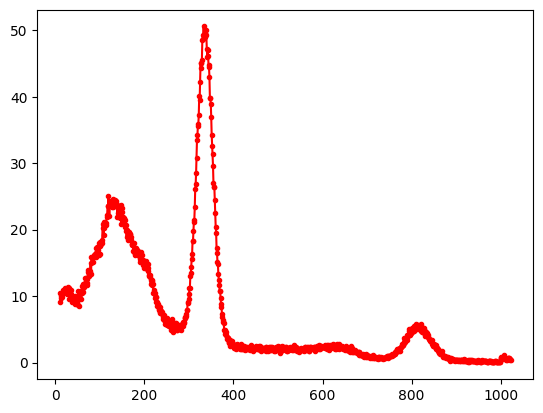

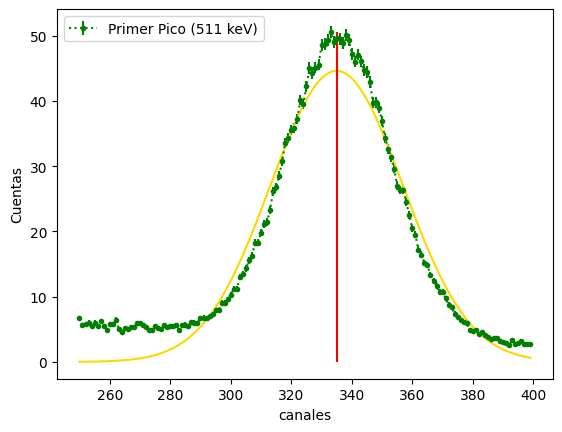

El maximo es en el canal:  335.0 y el sigma es:  21.89906263983182 La constante C es:  44.60188921882945
Las incertezas son:  [0.50502805 0.42903268 1.31805882]


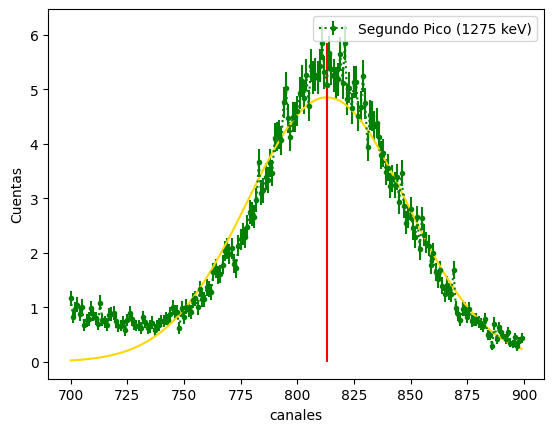

El maximo es en el canal:  813.0 y el sigma es:  35.04141465680397 La constante C es:  4.853566324626483
Las incertezas son:  [0.63787173 0.55740273 0.11141312]


In [9]:
print('Espectro Completo')
plt.plot(canales[10:], Na_I0[10:], marker='.', color='red')

print('Ajustes')
ploteo_gauss(canales[250:400], Na_I0[250:400], Na_I0_err[250:400], 300,2,1, "green","Primer Pico (511 keV)","canales", "Cuentas")
ploteo_gauss(canales[700:900], Na_I0[700:900], Na_I0_err[700:900], 700,2,1, "green","Segundo Pico (1275 keV)","canales", "Cuentas")

picos_Na=[335,813]
err_Na=[0.5,0.6]
E_Na=[511, 1275]

### Cesio 147

Espectro Completo
Ajustes


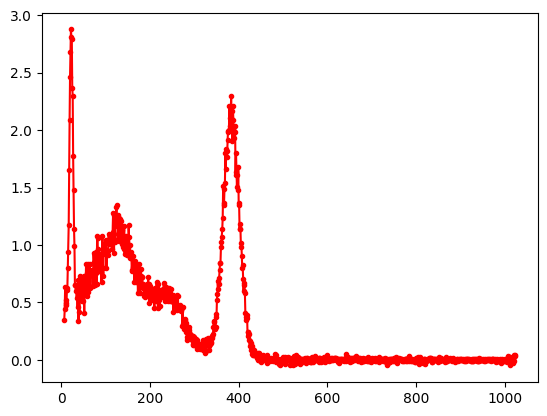

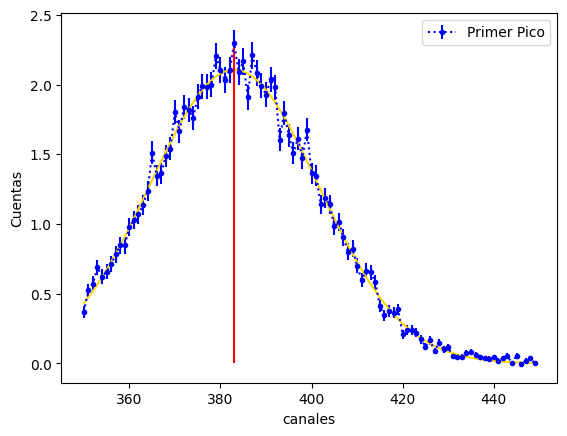

El maximo es en el canal:  383.0 y el sigma es:  18.529303125179094 La constante C es:  2.1058404206127093
Las incertezas son:  [0.1681143  0.14563226 0.02076172]


In [10]:
print('Espectro Completo')
plt.plot(canales[7:], Cs_I0[7:], marker='.', color='red')

print('Ajustes')
ploteo_gauss(canales[350:450], Cs_I0[350:450], Cs_I0_err[350:450], 375,5,1, "blue","Primer Pico","canales", "Cuentas")

picos_Cs=[383]
err_Cs=[0.2]
E_Cs=[662]

### Americio 241

Espectro Completo


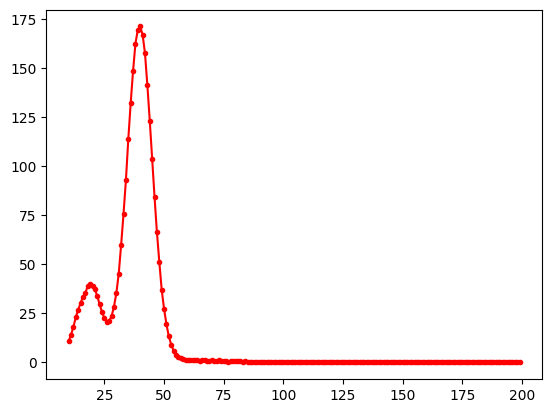

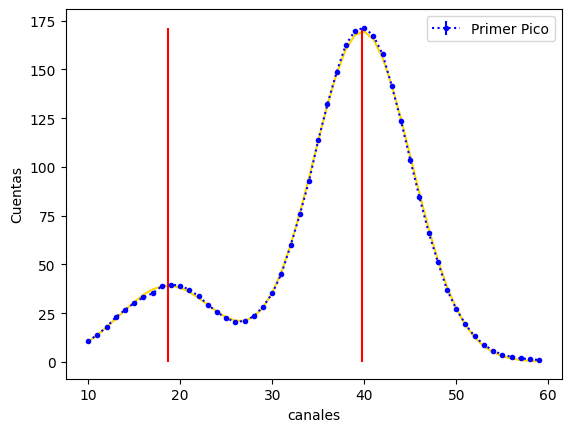

El maximo 1 esta en:  39.80266095631369 y el sigma es:  5.3413244453665465 La constante C es:  169.59113607550026
El maximo 2 esta en:  18.671267368622136 y el sigma es:  5.323817666460838 La constante C es:  39.053468950050615
Las incertezas son:  [0.02812969 0.02358245 0.98373866 0.07237667 0.08161597 0.52111507]


In [11]:
print('Espectro Completo')

plt.plot(canales[10:200], Am_I0[10:200], marker='.', color='red')

ploteo_Doble_gauss(canales[10:60], Am_I0[10:60], Am_I0_err[10:60], 22,5,1,40,2,1, "blue","Primer Pico","canales", "Cuentas")

picos_Am=[40]
err_Am=[0.1]
E_Am=[59]

### Bario 133

Espectro Completo
Ajustes


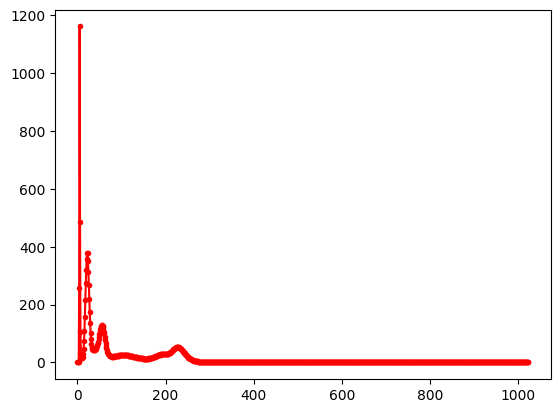

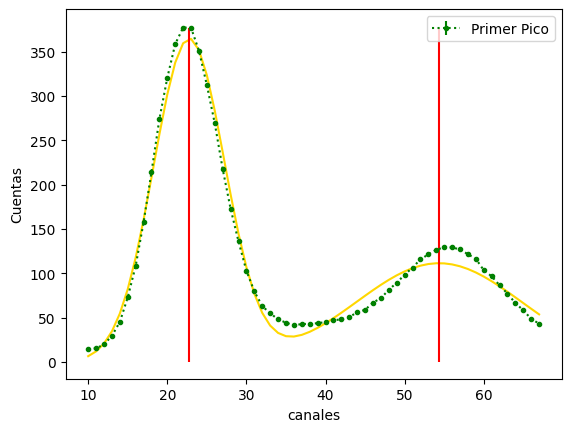

El maximo 1 esta en:  54.35828585113691 y el sigma es:  10.460491622926616 La constante C es:  111.3343450321629
El maximo 2 esta en:  22.759418816107175 y el sigma es:  4.495531630323721 La constante C es:  363.64936936987425
Las incertezas son:  [0.38282041 0.4560592  3.95828274 0.09888326 0.08068844 9.35062664]


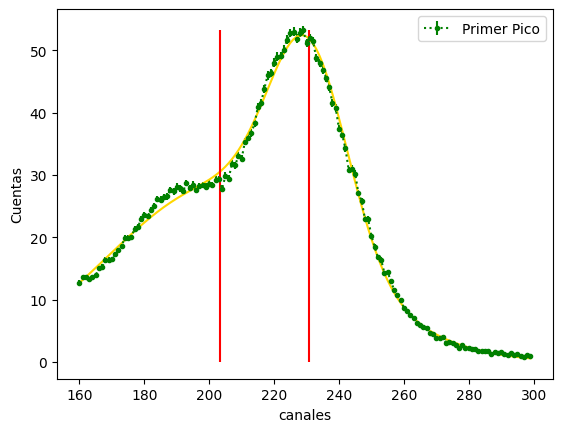

El maximo 1 esta en:  203.31672582479186 y el sigma es:  34.29687445077183 La constante C es:  28.160740820823708
El maximo 2 esta en:  230.66288453785955 y el sigma es:  12.006463177956071 La constante C es:  31.41882476232735
Las incertezas son:  [0.42427024 0.26498557 0.35504631 0.17348174 0.18882837 0.46306861]
picos


In [12]:
print('Espectro Completo')
#plt.semilogy(canales[10:243], Ba_I0[10:243], marker='.', color='red')
plt.plot(canales[:], Ba_I0[:], marker='.', color='red')


print('Ajustes')
ploteo_Doble_gauss(canales[10:68], Ba_I0[10:68], Ba_I0_err[10:68], 22,5,1,40,5,1, "green","Primer Pico","canales", "Cuentas")
ploteo_Doble_gauss(canales[160:300], Ba_I0[160:300], Ba_I0_err[160:300], 190,5,1,240,5,1, "green","Primer Pico","canales", "Cuentas")

print('picos')
picos_Ba=[23,54,231]
err_Ba=[0.4,0.1,0.4]
E_Ba=[31,81,356]

### Cobalto 60

Espectro Completo
Ajustes


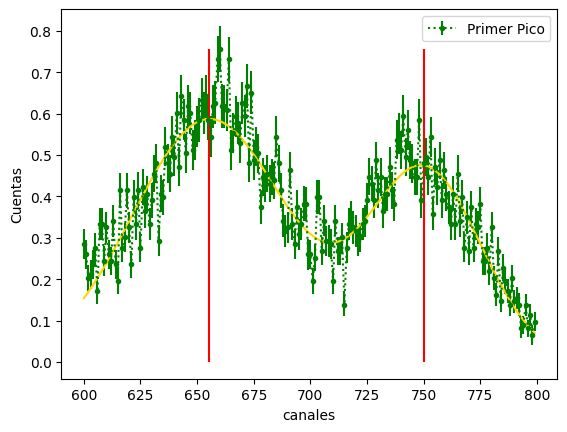

El maximo 1 esta en:  655.4183049268821 y el sigma es:  33.88145140852276 La constante C es:  0.5867615464353126
El maximo 2 esta en:  750.2228674665022 y el sigma es:  25.07169800115598 La constante C es:  0.4632560140354233
Las incertezas son:  [0.89935912 1.12034104 0.01277347 0.98547983 0.90468853 0.01249906]
picos


In [13]:
print('Espectro Completo')
#plt.semilogy(canales[:], Co_I0[:], marker='.', color='red')
#plt.plot(canales[:], Co_I0[:], marker='.', color='red')
#plt.xlim(600,800)

print('Ajustes')
ploteo_Doble_gauss(canales[600:800], Co_I0[600:800], Co_I0_err[600:800], 650,5,1,750,5,1, "green","Primer Pico","canales", "Cuentas")

print('picos')
picos_Co=[655,750]
err_Co=[1,1]
E_Co=[1173.2,1332.5]

## Energia vs Canales

In [14]:
Picos=[]
err_Picos=[]
Energias=[]

Picos+=picos_Ba
Picos+=picos_Am
Picos+=picos_Cs
#Picos+=picos_Na
Picos+=picos_Co

err_Picos+=err_Ba
err_Picos+=err_Am
err_Picos+=err_Cs
#err_Picos+=err_Na
err_Picos+=err_Co

Energias+=E_Ba
Energias+=E_Am
Energias+=E_Cs
#Energias+=E_Na
Energias+=E_Co

Picos=np.array(Picos)
err_Picos=np.array(err_Picos)
Energias=np.array(Energias)

In [15]:
def err_lineal(x,p,Dx,Dp,Db):
    sigma_y=np.sqrt((x*Dp)**2+(p*Dx)**2+(Db)**2)
    return sigma_y

1.7610894208763366 -13.412450325979039
0.0253386230089056 3.8213376459407455


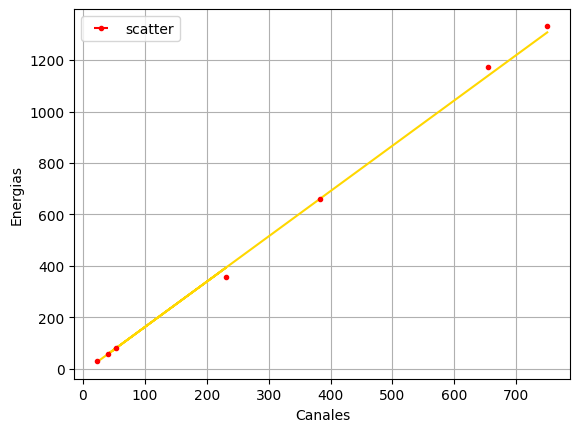

In [16]:
pop, cov= curve_fit(f=lineal, xdata= Picos, ydata= Energias, sigma= err_Picos, maxfev=1000000)

err_calibracion=np.sqrt(np.diag(cov))

print(pop[0], pop[1])
print(err_calibracion[0], err_calibracion[1])

pendiente= pop[0]
ordenada= pop[1]

err_p=err_calibracion[0]
err_b=err_calibracion[1]

Eje_Energia= pendiente*canales+ordenada
Eje_Energia_err= err_lineal(canales,pendiente, 1, err_p, err_b)

fig,ax = plt.subplots()
plt.errorbar(Picos, Energias, xerr=err_Picos, fmt="." , color='red' , label='scatter')
plt.plot(Picos, lineal(Picos, pop[0], pop[1]), color='gold')
plt.xlabel('Canales')
plt.ylabel('Energias')
plt.grid()
plt.legend()
plt.show()

# Corroboracion

## Cobalto 60

Espectro Completo
Ajustes


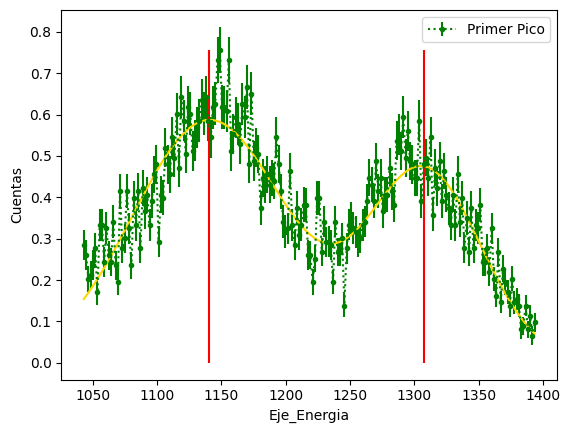

El maximo 1 esta en:  1140.83833915216 y el sigma es:  59.6688498644455 La constante C es:  0.5867602428293247
El maximo 2 esta en:  1307.7977633894445 y el sigma es:  44.15289938684816 La constante C es:  0.46325670732067187
Las incertezas son:  [1.58386258 1.97297964 0.0127736  1.73560056 1.5933404  0.01249876]
picos


In [17]:
print('Espectro Completo')
#plt.semilogy(Eje_Energia[:], Co_I0[:], marker='.', color='red')
#plt.plot(Eje_Energia[:], Co_I0[:], marker='.', color='red')
#plt.xlim(600,800)


print('Ajustes')
ploteo_Doble_gauss(Eje_Energia[600:800], Co_I0[600:800], Co_I0_err[600:800], 1100,5,1,1300,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")

print('picos')
picos_Co=[656,750]
E_Co_cal=[1141,1308]

## Bario 133

Espectro Completo
Ajustes


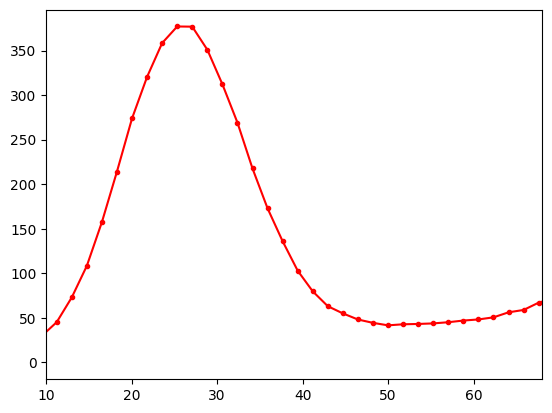

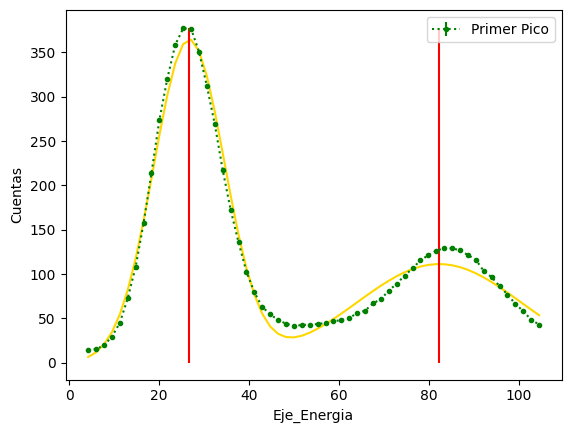

El maximo 1 esta en:  26.668926232200278 y el sigma es:  7.917038727310967 La constante C es:  363.649207553553
El maximo 2 esta en:  82.3173590180349 y el sigma es:  -18.42182363182559 La constante C es:  111.33447917120449
Las incertezas son:  [0.17414224 0.14209955 9.35061236 0.67417461 0.80315078 3.95829416]


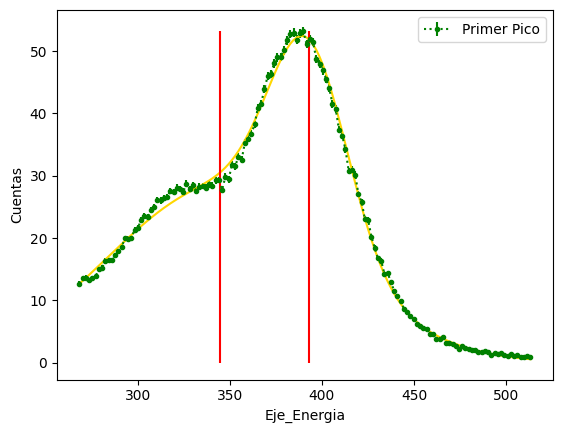

El maximo 1 esta en:  344.6465144310478 y el sigma es:  60.39984645442872 La constante C es:  28.160756990438053
El maximo 2 esta en:  392.80552910220865 y el sigma es:  21.14443741744663 La constante C es:  31.418817292374413
Las incertezas son:  [0.74718398 0.46666646 0.35504757 0.30551744 0.33254433 0.463069  ]
picos


In [18]:
print('Espectro Completo')
#plt.semilogy(Eje_Energia[10:243], Ba_I0[10:243], marker='.', color='red')
plt.plot(Eje_Energia[10:], Ba_I0[10:], marker='.', color='red')
plt.xlim(10,68)


print('Ajustes')
ploteo_Doble_gauss(Eje_Energia[10:68], Ba_I0[10:68], Ba_I0_err[10:68],31,5,1,40,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")
ploteo_Doble_gauss(Eje_Energia[160:300], Ba_I0[160:300], Ba_I0_err[160:300], 300,5,1,400,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")

print('picos')
picos_Ba=[23,55,230]
E_Ba_cal=[27,82,393]

## Sodio 22

Espectro Completo
Ajustes


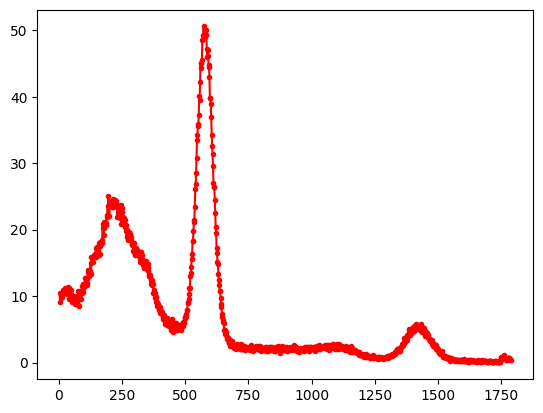

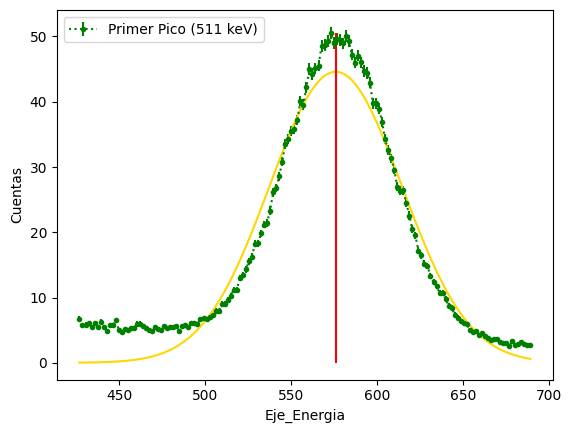

El maximo es en el canal:  576.0 y el sigma es:  38.56621344179868 La constante C es:  44.60188258894281
Las incertezas son:  [0.88939979 0.75556518 1.31805841]


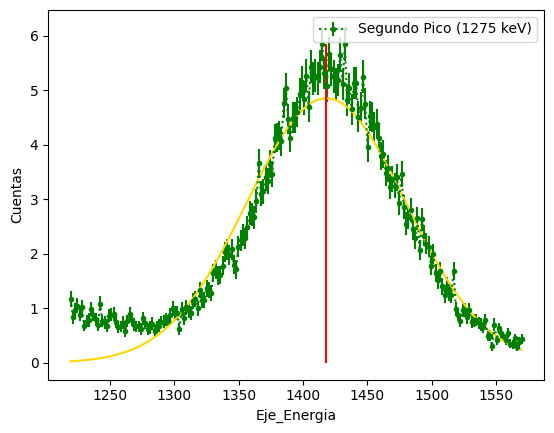

El maximo es en el canal:  1418.0 y el sigma es:  61.71015892256762 La constante C es:  4.853632992429882
Las incertezas son:  [1.1233125  0.98158952 0.11141656]


In [19]:
print('Espectro Completo')
plt.plot(Eje_Energia[10:], Na_I0[10:], marker='.', color='red')

print('Ajustes')
ploteo_gauss(Eje_Energia[250:400], Na_I0[250:400], Na_I0_err[250:400], 550,2,1, "green","Primer Pico (511 keV)","Eje_Energia", "Cuentas")
ploteo_gauss(Eje_Energia[700:900], Na_I0[700:900], Na_I0_err[700:900], 1400,2,1, "green","Segundo Pico (1275 keV)","Eje_Energia", "Cuentas")

picos_Na=[335, 814]
E_Na=[511,1275]

## Americio 241

El pico esta en:  59


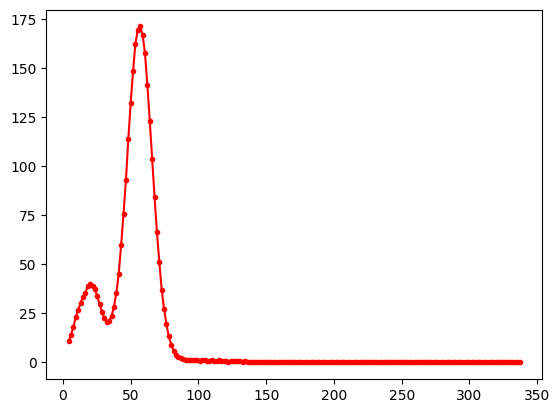

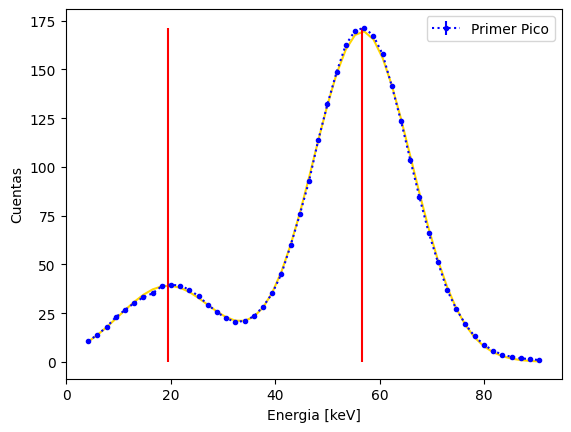

El maximo 1 esta en:  19.469322916177685 y el sigma es:  9.375721013294953 La constante C es:  39.053464917629945
El maximo 2 esta en:  56.68359528558169 y el sigma es:  9.4065495253451 La constante C es:  169.5911404452619
Las incertezas son:  [0.12746053 0.14373093 0.52111649 0.04953873 0.04153068 0.98373839]


In [20]:
print('El pico esta en: ', E_Am[0])
plt.plot(Eje_Energia[10:200], Am_I0[10:200], marker='.', color='red')

ploteo_Doble_gauss(Eje_Energia[10:60], Am_I0[10:60], Am_I0_err[10:60],22,5,1,E_Am[0],2,1, "blue","Primer Pico","Energia [keV]", "Cuentas")

picos_Am=[40]
E_Am_cal=[57]

## Cesio 147

El pico esta en:  662


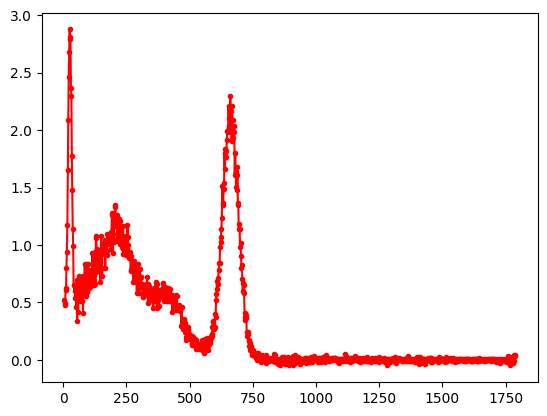

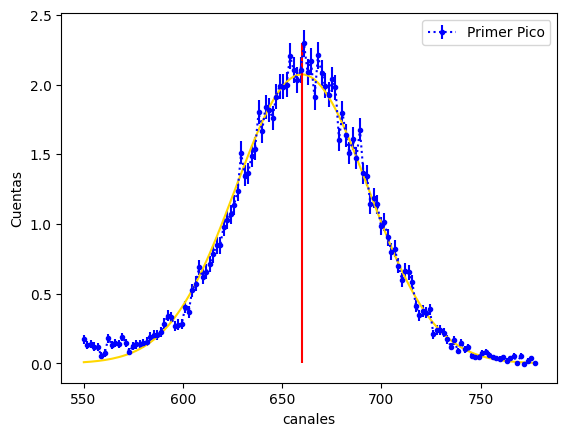

El maximo es en el canal:  660.0 y el sigma es:  33.40496318456752 La constante C es:  2.0727772956981627
Las incertezas son:  [0.39117602 0.31621023 0.02895493]


In [21]:
print('El pico esta en: ', E_Cs[0])

plt.plot(Eje_Energia[10:1024], Cs_I0[10:1024], marker='.', color='red')
ploteo_gauss(Eje_Energia[320:450], Cs_I0[320:450], Cs_I0_err[320:450], E_Cs[0],5,1, "blue","Primer Pico","canales", "Cuentas")

picos_Cs=[383]
E_Cs_cal=[660]

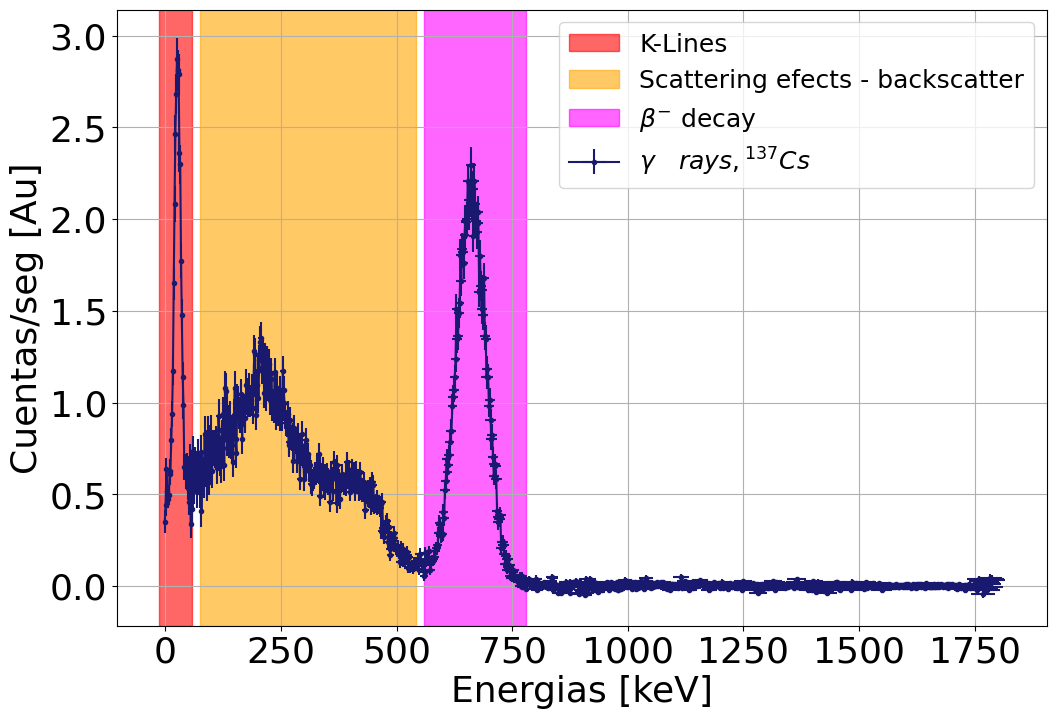

In [22]:
plt.figure(figsize=(12,8))

plt.errorbar(Eje_Energia[7:], Cs_I0[7:], yerr=Cs_I0_err[7:], xerr=Eje_Energia_err[7:], marker='.', color='midnightblue', label=r'$\gamma \quad rays, ^{137}Cs$')

plt.axvspan(Eje_Energia[0], Eje_Energia[40], color='red', alpha=0.6, label='K-Lines')
plt.axvspan(Eje_Energia[50], Eje_Energia[315], color='orange', alpha=0.6, label='Scattering efects - backscatter')
plt.axvspan(Eje_Energia[325], Eje_Energia[450], color='magenta', alpha=0.6, label=r'$\beta^{-}$ decay')

plt.xlabel('Energias [keV]', fontsize=26)
plt.ylabel('Cuentas/seg [Au]', fontsize=26)
plt.grid()
plt.legend(fontsize=18)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.savefig('Espectro_Cesio.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()

# Graficos atenuaciones completos

In [23]:
Am_u={}
Ba_u={}
Cs_u={}
Co_u={}
Na_u={}

for i in Datos.values():

    espesor=i[1]
    espesor_err=err_espesor(i[2], 0.05)
    data_norm=i[4]
    data_err=i[5]

    if i[0]=='Am241':
        Am_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Ba133':
        Ba_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Cs137':
        Cs_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Co60':
        Co_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Na22':
        Na_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]

Am = dict(sorted(Am_u.items()))
Ba = dict(sorted(Ba_u.items()))
Cs = dict(sorted(Cs_u.items()))
Co = dict(sorted(Co_u.items()))
Na = dict(sorted(Na_u.items()))

list_dicc=[Am, Ba, Cs, Co, Na]

In [24]:
Colores=['midnightblue','blue','blueviolet','darkviolet','purple','magenta','crimson','red']
titulos=['Atenuacion Americio', 'Atenuacion Bario', 'Atenuacion Cesio', 'Atenuacion Cobalto', 'Atenuacion Sodio']

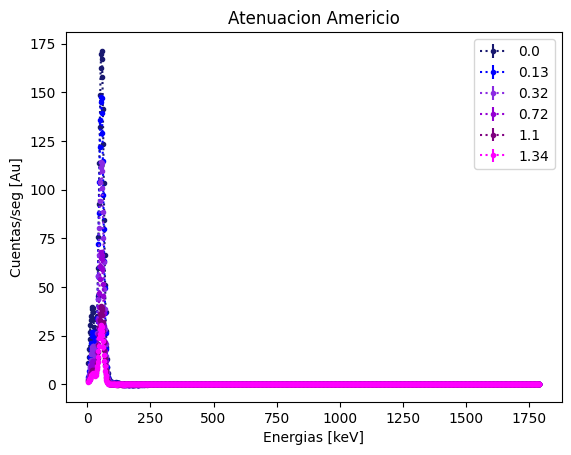

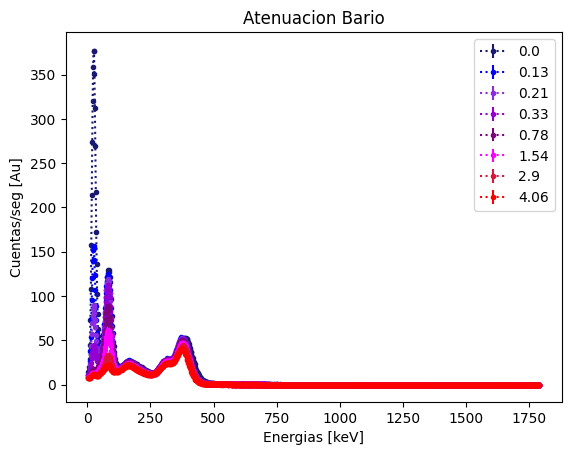

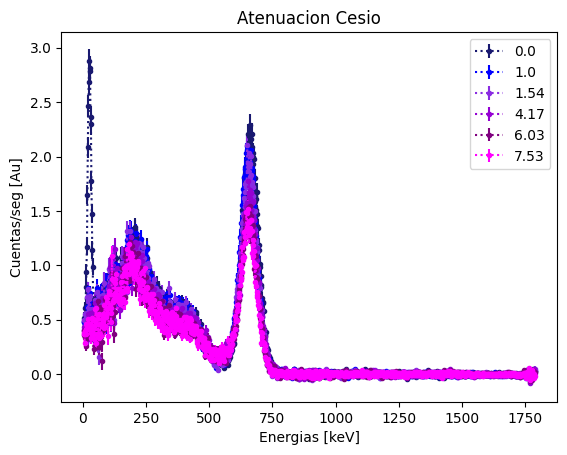

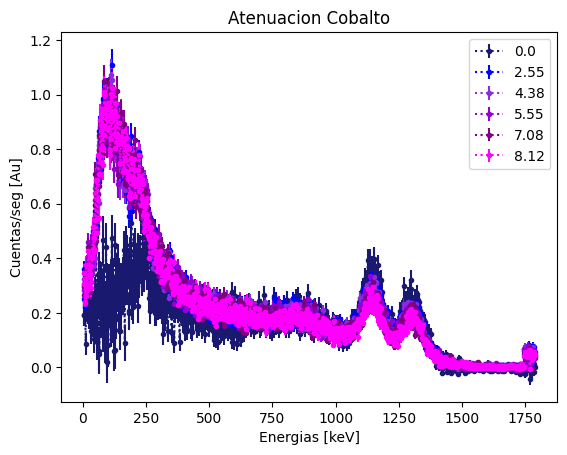

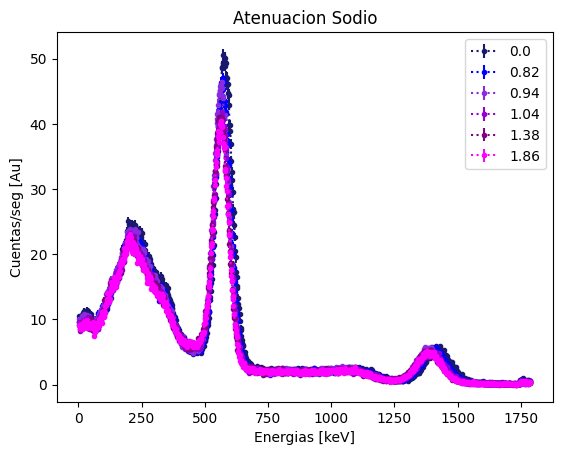

In [25]:
t=0

for dicc in list_dicc:

    c=0
    
    for esp in dicc.keys():

        plt.errorbar(Eje_Energia[10:], dicc[esp][0][10:], yerr=dicc[esp][1][10:], fmt='.:', color=Colores[c], label=str(esp))
        c=c+1
    
    plt.xlabel('Energias [keV]')
    plt.ylabel('Cuentas/seg [Au]')
    plt.title(titulos[t])
    plt.legend()
    plt.show()

    t=t+1


# Intensidades

## Integral Gausseana

In [26]:
def Gauss_int(sigma, Constante):
    return Constante*sigma*np.sqrt(2*np.pi)

def gauss(X,X_mean,sigma,C):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def Doble_gauss(X, X_mean1, sigma1, C1, X_mean2, sigma2, C2):
    return C1*np.exp(-(X-X_mean1)**2/(2*sigma1**2)) + C2*np.exp(-(X-X_mean2)**2/(2*sigma2**2))

In [27]:
#Error en el calculo del area:

def err_gauss(sigma, C, err_sigma, err_C):

    return np.sqrt((2*np.pi)*(sigma*err_C)**2+(C*err_sigma)**2)

### Sodio

In [28]:
#Error Espesor
List_err_Esp_Na=[]

for i in Na.values():
    List_err_Esp_Na.append(i[2])

Esp_Na_err=np.array(List_err_Esp_Na)

Primer Pico

Espesor:  0.0 sigma=  38.566183727931545 +- 0.7555581049400087 Constante= 44.601915889215796
Espesor:  0.82 sigma=  38.89172852850608 +- 0.7862690056014336 Constante= 40.059004788902534
Espesor:  0.94 sigma=  38.860038085441744 +- 0.7569902351248544 Constante= 39.92628599892839
Espesor:  1.04 sigma=  40.81924021020282 +- 0.8633873139672584 Constante= 35.3916414626485
Espesor:  1.38 sigma=  40.797764880586904 +- 0.8704543451573621 Constante= 34.97991705669228
Espesor:  1.86 sigma=  41.212652182590745 +- 0.8907037098384402 Constante= 33.81587760636265


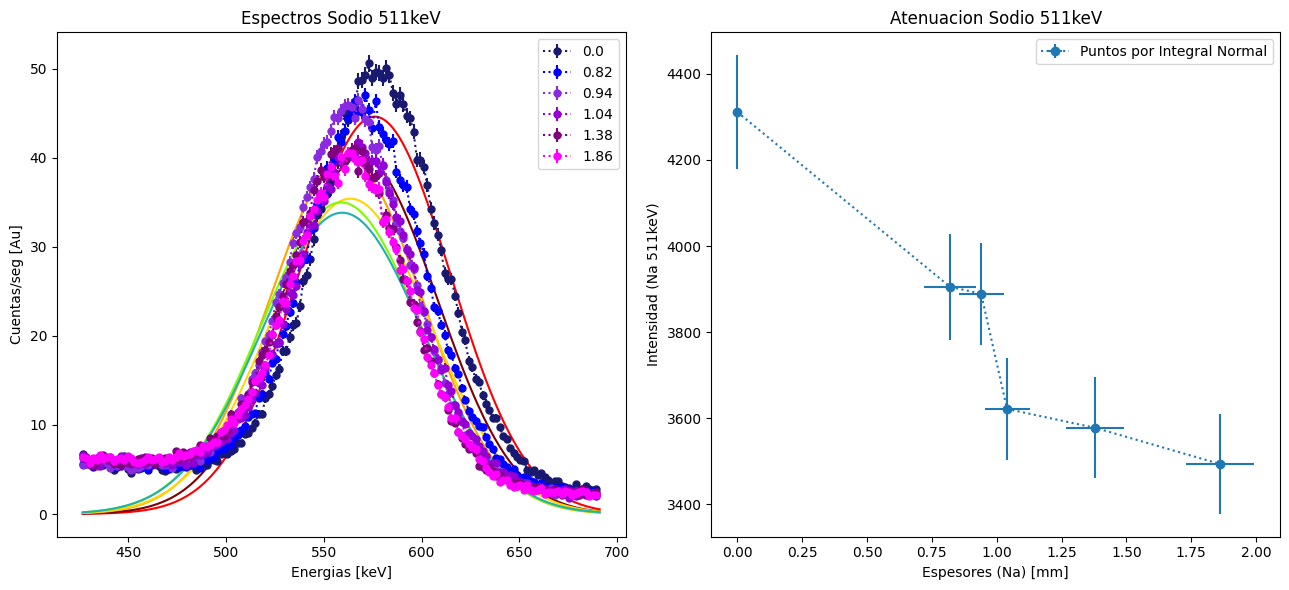

In [29]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[250], Eje_Energia[400], 1000)

Int_Sodio_511_g=[]
List_err_Int_Na_511=[]
List_Esp_Na=[]

c=0

for esp in Na.keys():
    List_Esp_Na+=[esp]

Esp_Na=np.array(List_Esp_Na)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Na.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[250:400], Na[esp][0][250:400], sigma=Na[esp][1][250:400], p0=[E_Na[0],2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Sodio_511_g.append(Int_g)

    #Error Calculo del area:
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Na_511.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[250:400], Na[esp][0][250:400], yerr=Na[esp][1][250:400], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Sodio 511keV')
ax1.legend()

ax2.errorbar(Esp_Na, np.array(Int_Sodio_511_g), yerr=np.array(List_err_Int_Na_511), xerr= Esp_Na_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Sodio 511keV')
ax2.set_xlabel('Espesores (Na) [mm]')
ax2.set_ylabel('Intensidad (Na 511keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Segundo Pico

Espesor:  0.0 sigma=  61.71101919304061 +- 0.9816239001266562 Constante= 4.8535696708924005
Espesor:  0.82 sigma=  60.522059135807886 +- 0.8364876700028586 Constante= 4.813741053285681
Espesor:  0.94 sigma=  60.18500231083101 +- 0.7211595015559517 Constante= 4.826684963022504
Espesor:  1.04 sigma=  61.019934506591305 +- 0.7588793060009127 Constante= 4.446456272154198
Espesor:  1.38 sigma=  60.193283004628924 +- 0.7453764027192162 Constante= 4.427556148975955
Espesor:  1.86 sigma=  60.0364471585624 +- 0.7426357334773079 Constante= 4.383063471974094


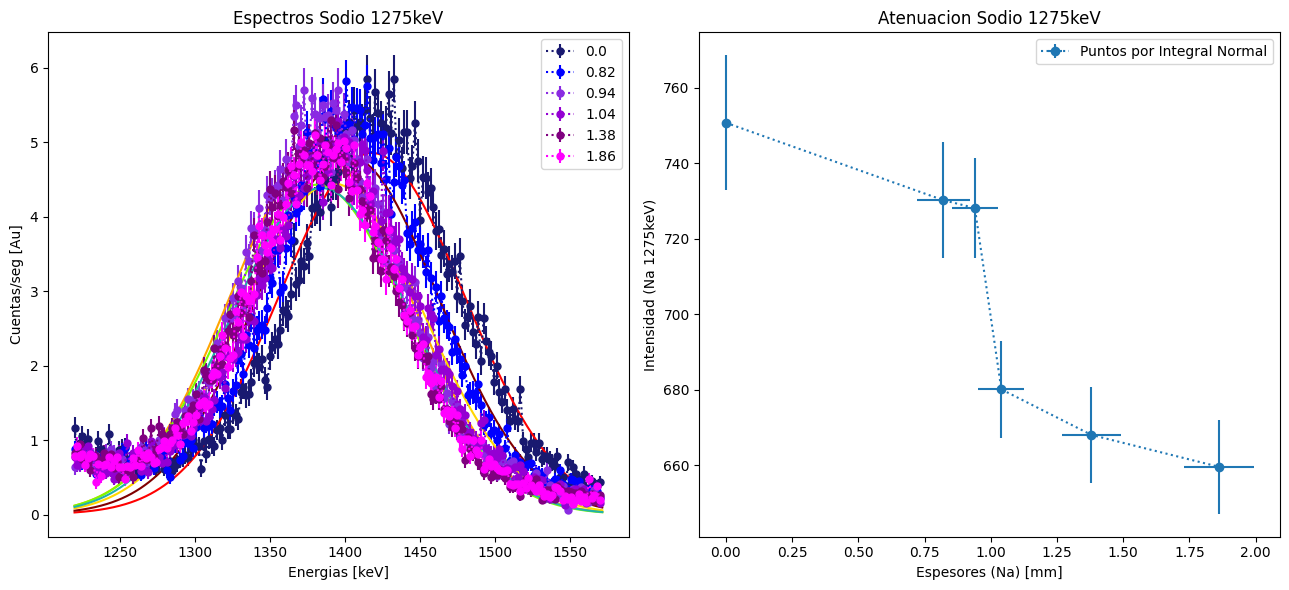

In [30]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[700], Eje_Energia[900], 1000)

Int_Sodio_1275_g=[]
List_err_Int_Na_1275=[]
List_Esp_Na=[]

c=0

for esp in Na.keys():
    List_Esp_Na+=[esp]

Esp_Na=np.array(List_Esp_Na)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Na.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[700:900], Na[esp][0][700:900], sigma=Na[esp][1][700:900],p0=[1400,2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Sodio_1275_g.append(Int_g)
    
    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Na_1275.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[700:900], Na[esp][0][700:900], yerr=Na[esp][1][700:900],fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Sodio 1275keV')
ax1.legend()

ax2.errorbar(Esp_Na, np.array(Int_Sodio_1275_g), yerr=np.array(List_err_Int_Na_1275) ,xerr=Esp_Na_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Sodio 1275keV')
ax2.set_xlabel('Espesores (Na) [mm]')
ax2.set_ylabel('Intensidad (Na 1275keV)')
ax2.legend()

plt.tight_layout()
plt.show()

### Cesio

In [31]:
#Error Espesor
List_err_Esp_Cs=[]

for i in Cs.values():
    List_err_Esp_Cs.append(i[2])

Esp_Cs_err=np.array(List_err_Esp_Cs)
#--------------------------------------

Espesor:  0.0 sigma=  33.40497164253839 +- 0.31620996037582527 Constante= 2.072776827223293
Espesor:  1.0 sigma=  33.66092310791255 +- 0.33351547455207897 Constante= 1.9356927729789322
Espesor:  1.54 sigma=  33.830825418662 +- 0.35806796163988375 Constante= 1.8308736864522015
Espesor:  4.17 sigma=  35.70335003794542 +- 0.4443076913752657 Constante= 1.5583060116352605
Espesor:  6.03 sigma=  35.43440895342055 +- 0.45947699202758213 Constante= 1.3917235533944345
Espesor:  7.53 sigma=  36.045885837453305 +- 0.5348582783812805 Constante= 1.2943818013257122


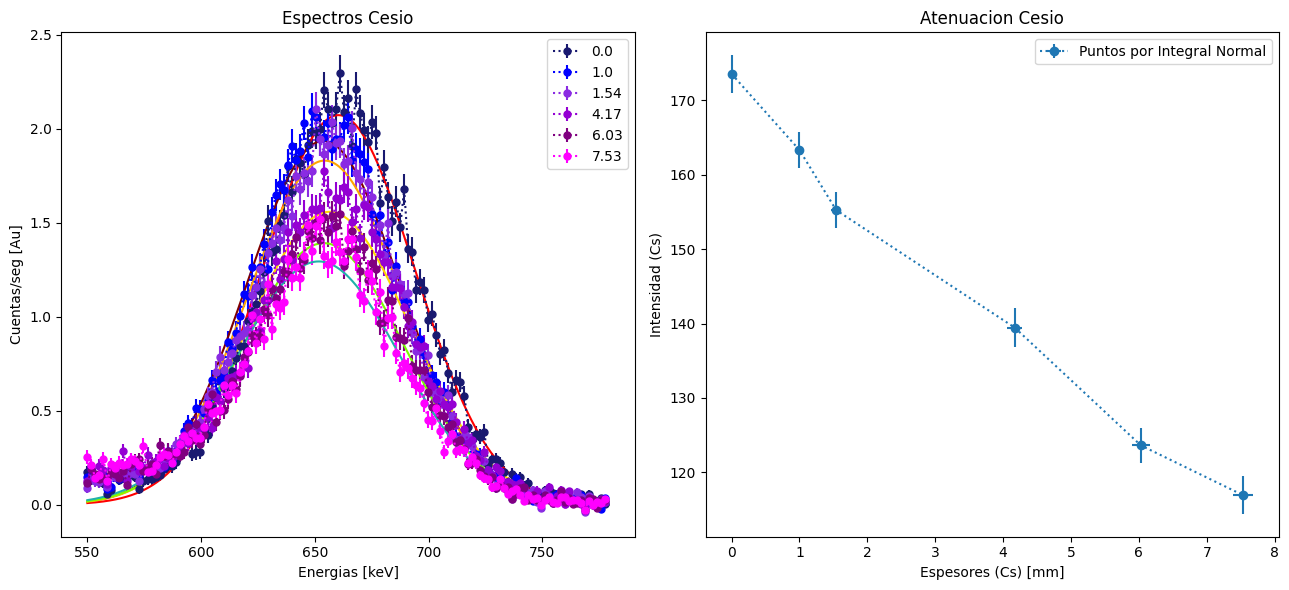

In [32]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[320], Eje_Energia[450], 1000)

Int_Cesio_g=[]
List_err_Int_Cs=[]
List_Esp_Cs=[]

c=0

for esp in Cs.keys():
    List_Esp_Cs+=[esp]

Esp_Cs=np.array(List_Esp_Cs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Cs.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[320:450], Cs[esp][0][320:450], sigma=Cs[esp][1][320:450], p0=[E_Cs[0],2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Cesio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Cs.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[320:450], Cs[esp][0][320:450], yerr=Cs[esp][1][320:450], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cesio')
ax1.legend()

ax2.errorbar(Esp_Cs, np.array(Int_Cesio_g), yerr=np.array(List_err_Int_Cs), xerr= Esp_Cs_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cesio')
ax2.set_xlabel('Espesores (Cs) [mm]')
ax2.set_ylabel('Intensidad (Cs)')
ax2.legend()

plt.tight_layout()
plt.show()


#array errores en la integral:
Int_Cesio_g_err=np.array(List_err_Int_Cs)


### Cobalto

Primer Pico

Aca el pico de I0, (respectivo a espesor '0.00') no da, por eso lo saco.

Espesor:  0.0 sigma=  53.605997046113316 +- 1.439943737504916 Constante= 0.3126039591036335
Espesor:  4.38 sigma=  58.419262882147706 +- 1.3835032644411982 Constante= 0.2726405026352039
Espesor:  5.55 sigma=  60.49557233484342 +- 1.4059399310788365 Constante= 0.25521181511927227
Espesor:  7.08 sigma=  62.992838286865556 +- 1.6646535557732554 Constante= 0.2340987889281344
Espesor:  8.12 sigma=  65.82891554931332 +- 1.448108872748131 Constante= 0.2226162326196051


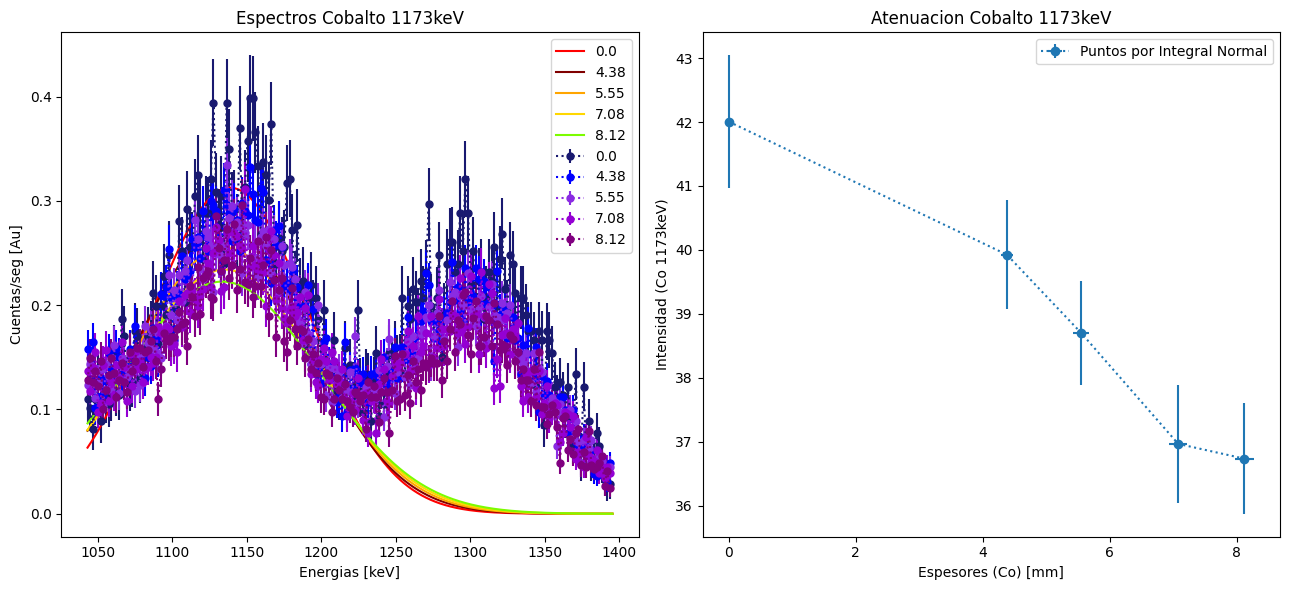

In [33]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[600], Eje_Energia[800], 1000)

Int_Cobalto_1173_g=[]
List_err_Int_Co_1173=[]
List_Esp_Co_1173=[]
List_Esp_Co_1173_err=[]

c=0

for esp in Co.keys():
    if esp!=2.55:
        List_Esp_Co_1173+=[esp]
        List_Esp_Co_1173_err.append(Co[esp][2])

Esp_Co_1173=np.array(List_Esp_Co_1173)
Esp_Co_1173_err=np.array(List_Esp_Co_1173_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Co.keys():

    if esp!=2.55:

        pop, cov= curve_fit(Doble_gauss, Eje_Energia[600:800], Co[esp][0][600:800], sigma=Co[esp][1][600:800], p0=[1100,5,1,1300,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

        err=np.sqrt(np.diag(cov))

        mu=pop[0]
        sigma=pop[1]
        Const=pop[2]

        print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

        Int_g=Gauss_int(sigma, Const)
        Int_Cobalto_1173_g.append(Int_g)

        #Error Calculo del Area
        err_Int_g=err_gauss(sigma, Const, err[1], err[2])
        List_err_Int_Co_1173.append(err_Int_g)
        
        ax1.errorbar(Eje_Energia[600:800], Co[esp][0][600:800], yerr=Co[esp][1][600:800], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
        ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c], label=str(esp))
        c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cobalto 1173keV')
ax1.legend()

ax2.errorbar(Esp_Co_1173, np.array(Int_Cobalto_1173_g), yerr=np.array(List_err_Int_Co_1173), xerr= Esp_Co_1173_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cobalto 1173keV')
ax2.set_xlabel('Espesores (Co) [mm]')
ax2.set_ylabel('Intensidad (Co 1173keV)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Cobalto_1173_g_err=np.array(List_err_Int_Co_1173)


Segundo Pico

Espesor:  0.0 sigma=  44.00516112966776 +- 1.439943737504916 Constante= 0.24348411211616425
Espesor:  2.55 sigma=  46.76056894441373 +- 1.3339344065994572 Constante= 0.21141952598018218
Espesor:  4.38 sigma=  45.92449050923104 +- 1.3835032644411982 Constante= 0.20468282804026505
Espesor:  5.55 sigma=  46.01667306618212 +- 1.4059399310788365 Constante= 0.19206492397528085
Espesor:  7.08 sigma=  45.597677702469554 +- 1.6646535557732554 Constante= 0.1766699726288353
Espesor:  8.12 sigma=  43.5139554106919 +- 1.448108872748131 Constante= 0.16963118428911567


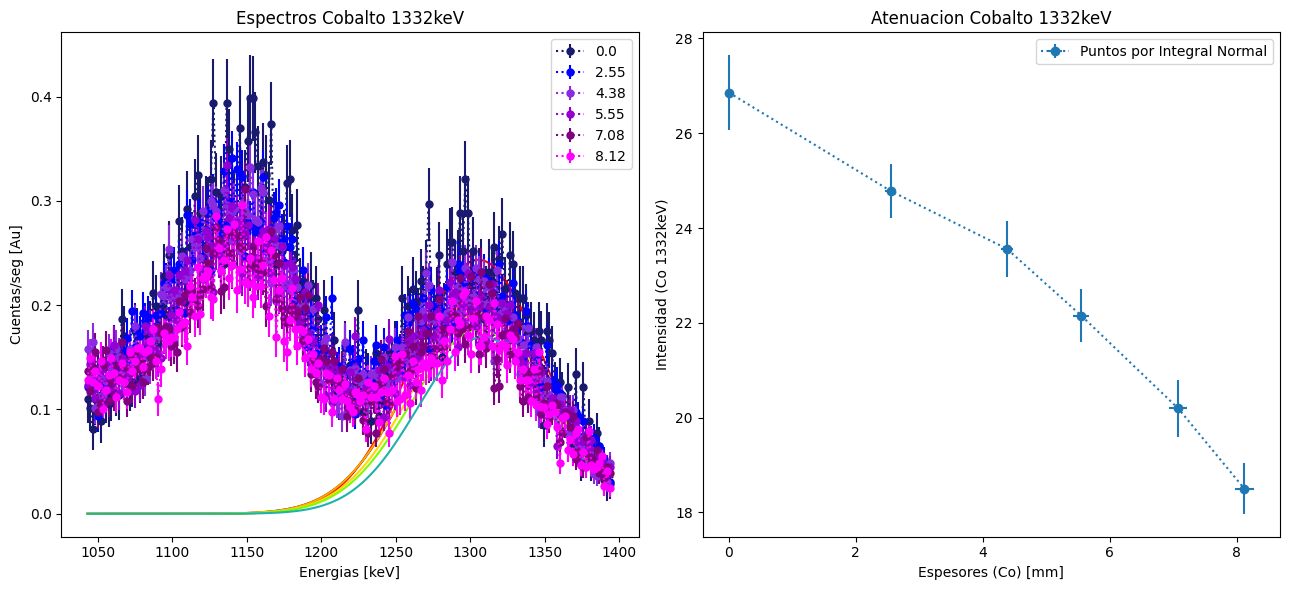

In [34]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[600], Eje_Energia[800], 1000)

Int_Cobalto_1332_g=[]
List_err_Int_Co_1332=[]
List_Esp_Co_1332=[]
List_Esp_Co_1332_err=[]

c=0

for esp in Co.keys():

    List_Esp_Co_1332+=[esp]
    List_Esp_Co_1332_err.append(Co[esp][2])

Esp_Co_1332=np.array(List_Esp_Co_1332)
Esp_Co_1332_err=np.array(List_Esp_Co_1332_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Co.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[600:800], Co[esp][0][600:800], sigma=Co[esp][1][600:800], p0=[1100,5,1,1300,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Cobalto_1332_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Co_1332.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[600:800], Co[esp][0][600:800], yerr=Co[esp][1][600:800], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cobalto 1332keV')
ax1.legend()

ax2.errorbar(Esp_Co_1332, np.array(Int_Cobalto_1332_g), yerr=np.array(List_err_Int_Co_1332), xerr= Esp_Co_1332_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cobalto 1332keV')
ax2.set_xlabel('Espesores (Co) [mm]')
ax2.set_ylabel('Intensidad (Co 1332keV)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Cobalto_1332_g_err=np.array(List_err_Int_Co_1332)

### Bario

Primer Pico

0.0
0.13
0.21
0.33
4.06
[0.   0.13 0.21 0.33 4.06]
Espesor:  0.0 sigma=  7.982359760114225 +- 0.9214658549782061 Constante= 361.42017301623633
Espesor:  0.13 sigma=  8.94199585203622 +- 0.6104900547128665 Constante= 142.15824381629233
Espesor:  0.21 sigma=  10.810686864851055 +- 0.5392218171174289 Constante= 76.28903550589015
Espesor:  0.33 sigma=  16.232151257918762 +- 0.4105183870189891 Constante= 37.38284801578421
Espesor:  4.06 sigma=  23.91286539945812 +- 1.1711850400134742 Constante= 10.051403704707353


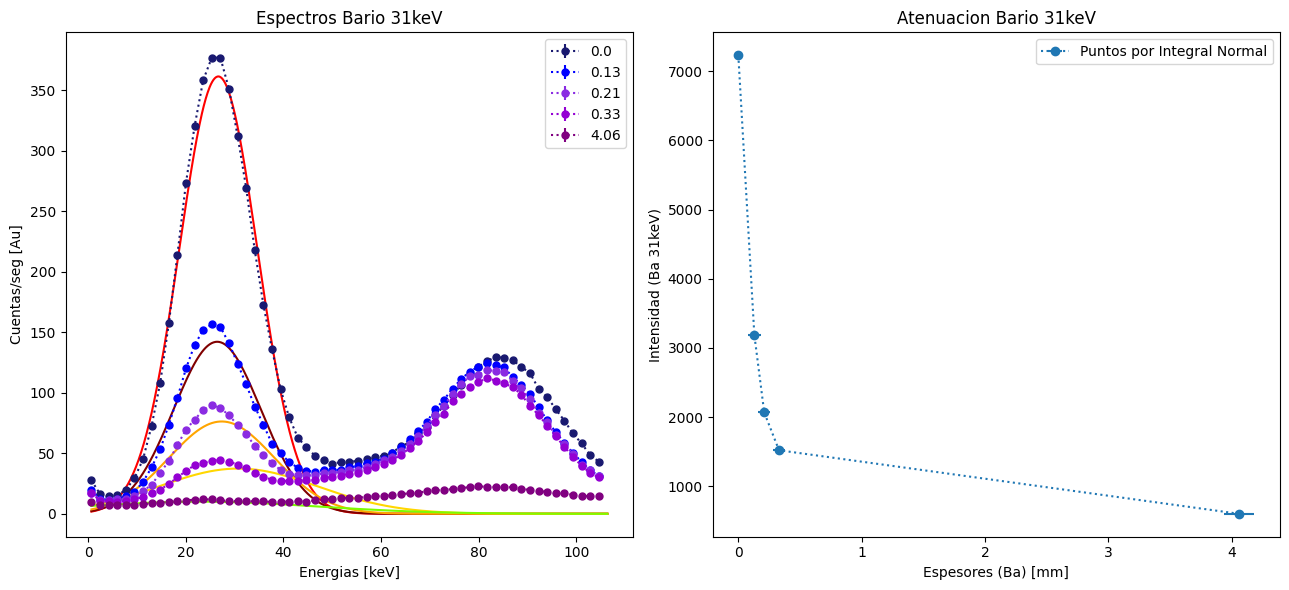

In [35]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[8], Eje_Energia[68], 800)

Int_Bario_31_g=[]
List_err_Int_Ba_31=[]
List_Esp_Ba_31=[]
List_Esp_Ba_31_err=[]

c=0

for esp in Ba.keys():
    
    if esp!=0.78 and esp!=1.54 and esp!=2.9:

        print(esp)
        List_Esp_Ba_31+=[esp]
        List_Esp_Ba_31_err.append(Ba[esp][2])

Esp_Ba_31=np.array(List_Esp_Ba_31)
Esp_Ba_31_err=np.array(List_Esp_Ba_31_err)

print(Esp_Ba_31)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():
        
    if esp!=0.78 and esp!=1.54 and esp!=2.9:

        pop, cov= curve_fit(Doble_gauss, Eje_Energia[8:68], Ba[esp][0][8:68], sigma=Ba[esp][1][8:68], p0=[20,5,1,80,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

        err=np.sqrt(np.diag(cov))

        mu=pop[0]
        sigma=pop[1]
        Const=pop[2]

        print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

        Int_g=Gauss_int(sigma, Const)
        Int_Bario_31_g.append(Int_g)

        #Error Calculo del Area
        err_Int_g=err_gauss(sigma, Const, err[1], err[2])
        List_err_Int_Ba_31.append(err_Int_g)
        
        ax1.errorbar(Eje_Energia[8:68], Ba[esp][0][8:68], yerr=Ba[esp][1][8:68], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
        ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])

        c=c+1


ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 31keV')
ax1.legend()

ax2.errorbar(Esp_Ba_31, np.array(Int_Bario_31_g),  xerr= Esp_Ba_31_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 31keV')
ax2.set_xlabel('Espesores (Ba) [mm]')
ax2.set_ylabel('Intensidad (Ba 31keV)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Bario_31_g_err=np.array(List_err_Int_Ba_31)

Segundo Pico

Espesor:  0.0 sigma=  17.147843421383037 +- 0.5494130623902269 Constante= 114.3221053739436
Espesor:  0.13 sigma=  16.40662832444217 +- 0.6263927273347669 Constante= 108.92056264680141
Espesor:  0.21 sigma=  16.427095067859717 +- 0.6257137533401314 Constante= 104.30342344270306
Espesor:  0.33 sigma=  16.539176074122643 +- 0.6230458249504552 Constante= 97.94612387066651
Espesor:  0.78 sigma=  17.551171114451485 +- 0.7547956446762603 Constante= 76.57649916402463
Espesor:  1.54 sigma=  19.972601138303723 +- 0.959744702190311 Constante= 51.32084698885847
Espesor:  2.9 sigma=  27.709278788251005 +- 1.762378422925534 Constante= 27.97568248740016


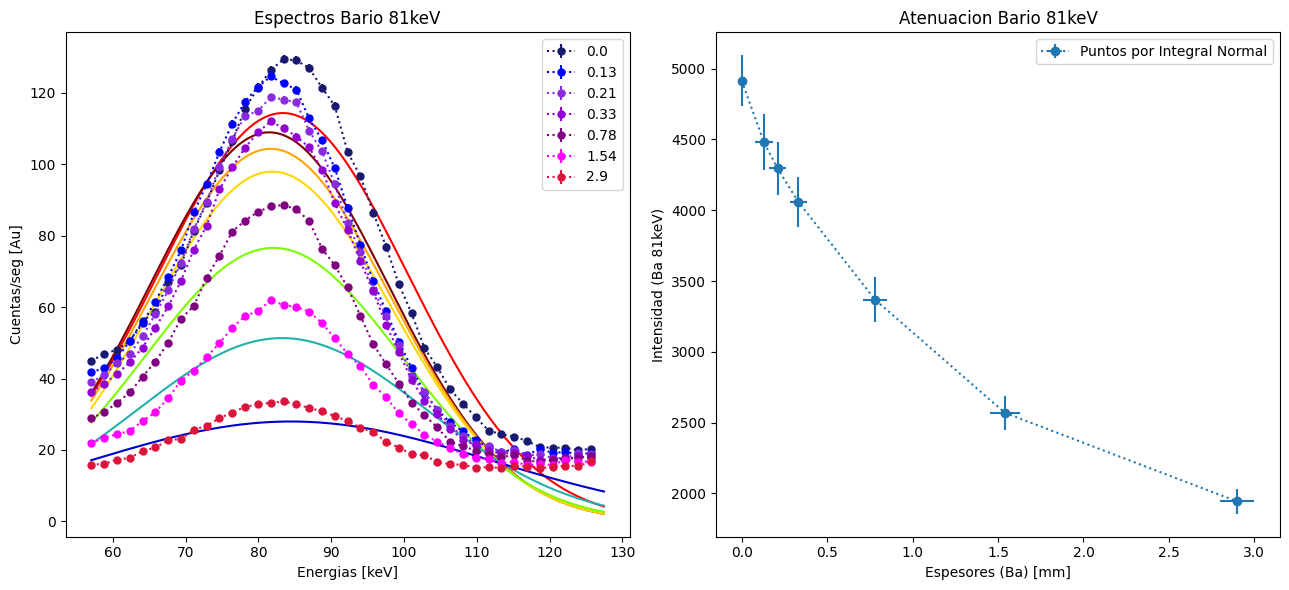

[0.   0.13 0.21 0.33 4.06]


In [36]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[40], Eje_Energia[80], 800)

Int_Bario_81_g=[]
List_err_Int_Ba_81=[]
List_Esp_Ba_81=[]
List_Esp_Ba_81_err=[]

c=0

for esp in Ba.keys():
    
    if esp!=4.06:

        List_Esp_Ba_81+=[esp]
        List_Esp_Ba_81_err.append(Ba[esp][2])

Esp_Ba_81=np.array(List_Esp_Ba_81)
Esp_Ba_81_err=np.array(List_Esp_Ba_81_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():
    
    if esp!=4.06:
    
        pop, cov= curve_fit(gauss, Eje_Energia[40:80], Ba[esp][0][40:80], sigma=Ba[esp][1][40:80], p0=[80,2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

        err=np.sqrt(np.diag(cov))

        mu=pop[0]
        sigma=pop[1]
        Const=pop[2]

        print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

        Int_g=Gauss_int(sigma, Const)
        Int_Bario_81_g.append(Int_g)

        #Error Calculo del Area
        err_Int_g=err_gauss(sigma, Const, err[1], err[2])
        List_err_Int_Ba_81.append(err_Int_g)
        
        ax1.errorbar(Eje_Energia[40:80], Ba[esp][0][40:80], yerr=Ba[esp][1][40:80], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
        ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])
        c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 81keV')
ax1.legend()

ax2.errorbar(Esp_Ba_81, np.array(Int_Bario_81_g), yerr=np.array(List_err_Int_Ba_81), xerr=Esp_Ba_81_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 81keV')
ax2.set_xlabel('Espesores (Ba) [mm]')
ax2.set_ylabel('Intensidad (Ba 81keV)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Bario_81_g_err=np.array(List_err_Int_Ba_81)

print(Esp_Ba_31)

Tercer Pico

Espesor:  0.0 sigma=  21.896688168306348 +- 0.3939914697807398 Constante= 32.6856082243082
Espesor:  0.13 sigma=  20.716646446348076 +- 0.350515625313274 Constante= 32.15517277599607
Espesor:  0.21 sigma=  20.691787799540723 +- 0.35833299600130947 Constante= 32.4480207960759
Espesor:  0.33 sigma=  20.693778492616474 +- 0.3631125908090694 Constante= 31.809010880714673
Espesor:  0.78 sigma=  20.749522927736177 +- 0.36334815955312316 Constante= 30.98618091868807
Espesor:  1.54 sigma=  21.104846823264005 +- 0.3220916172031975 Constante= 29.66843195997816


Espesor:  2.9 sigma=  21.32132357907459 +- 0.3476215658714774 Constante= 27.52810613599562
Espesor:  4.06 sigma=  21.343468785727172 +- 0.3021315937100076 Constante= 25.478204064452907


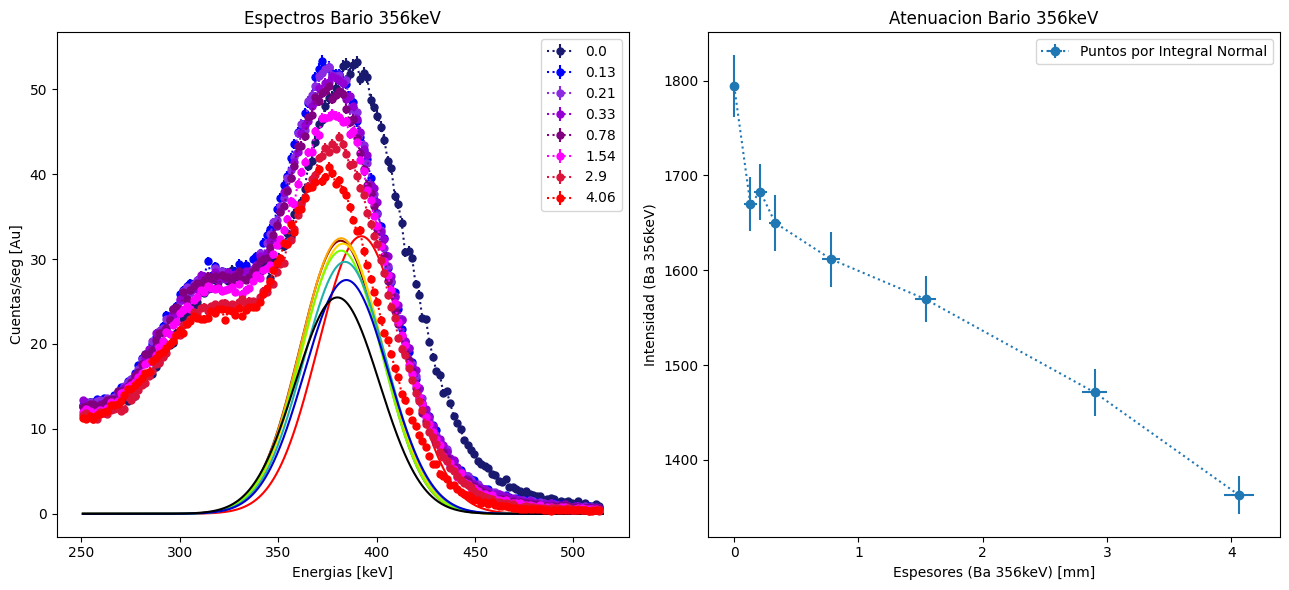

[0.   0.13 0.21 0.33 4.06]


In [37]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[150], Eje_Energia[300], 1000)

Int_Bario_356_g=[]
List_err_Int_Ba_356=[]
List_Esp_Ba_356=[]
List_Esp_Ba_356_err=[]

c=0

for esp in Ba.keys():

    List_Esp_Ba_356+=[esp]
    List_Esp_Ba_356_err.append(Ba[esp][2])

Esp_Ba_356=np.array(List_Esp_Ba_356)
Esp_Ba_356_err=np.array(List_Esp_Ba_356_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[150:300], Ba[esp][0][150:300], sigma=Ba[esp][1][150:300], p0=[300,15,30,400,15,80], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Bario_356_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Ba_356.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[150:300], Ba[esp][0][150:300], yerr=Ba[esp][1][150:300], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    #ax1.plot(Dom, gauss(Dom,pop[0], pop[1], pop[2]), color=Colores_plot[c])
    ax1.plot(Dom, gauss(Dom,pop[3], pop[4], pop[5]), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 356keV')
ax1.legend()

ax2.errorbar(Esp_Ba_356, np.array(Int_Bario_356_g), yerr=np.array(List_err_Int_Ba_356),xerr= Esp_Ba_356_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 356keV')
ax2.set_xlabel('Espesores (Ba 356keV) [mm]')
ax2.set_ylabel('Intensidad (Ba 356keV)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Bario_356_g_err=np.array(List_err_Int_Ba_356)

print(Esp_Ba_31)

### Americio

Espesor:  0.0 sigma=  9.409654102936468 +- 0.0524277684233578 Constante= 169.5355735847401
Espesor:  0.13 sigma=  9.242738512922159 +- 0.06484899654684592 Constante= 147.01016018151262
Espesor:  0.32 sigma=  9.20044158878763 +- 0.05845519695882931 Constante= 114.016252048359
Espesor:  0.72 sigma=  9.211100894568945 +- 0.060755028647599574 Constante= 66.91572942332917
Espesor:  1.1 sigma=  9.307432655151784 +- 0.05936793194419316 Constante= 40.0775708424164
Espesor:  1.34 sigma=  9.4007310017143 +- 0.057679440194429915 Constante= 30.003711291350218


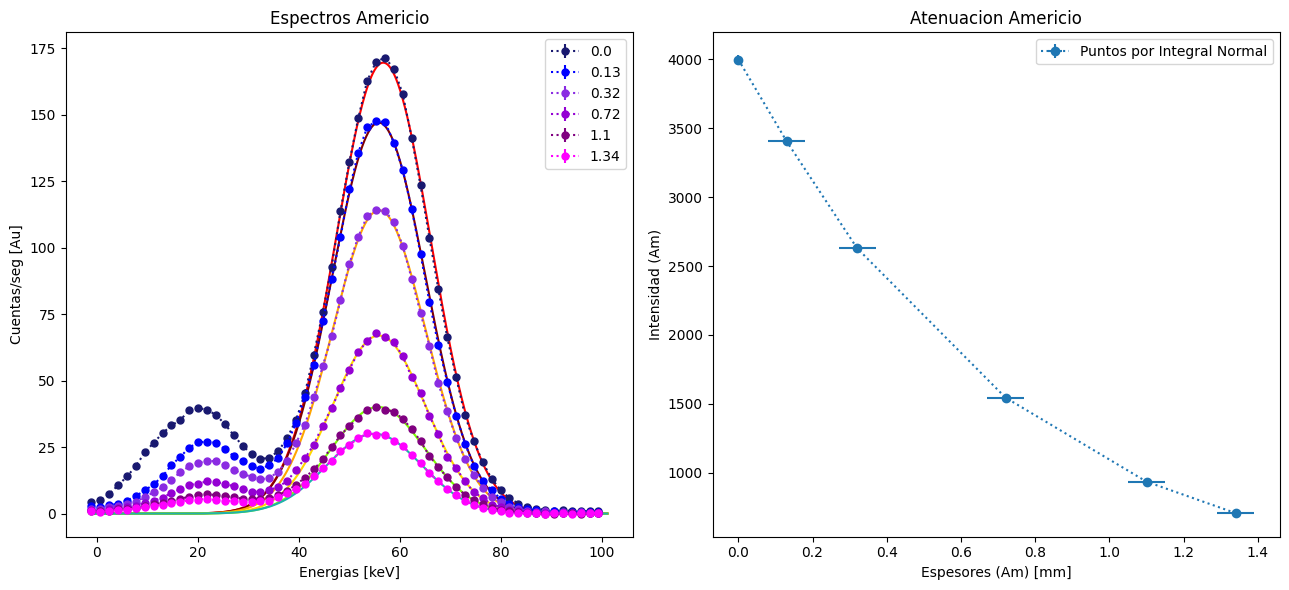

In [38]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[7], Eje_Energia[65], 1000)

Int_Americio_g=[]
List_err_Int_Am=[]
List_Esp_Am=[]
List_Esp_Am_err=[]

c=0

for esp in Am.keys():

    List_Esp_Am+=[esp]
    List_Esp_Am_err.append(Am[esp][2])

Esp_Am=np.array(List_Esp_Am)
Esp_Am_err=np.array(List_Esp_Am_err)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Am.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[7:65], Am[esp][0][7:65], sigma=Am[esp][1][7:65], p0=[22,5,1,E_Am[0],2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Americio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Am.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[7:65], Am[esp][0][7:65], yerr=Am[esp][1][7:65], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Americio')
ax1.legend()

ax2.errorbar(Esp_Am, np.array(Int_Americio_g),yerr=np.array(List_err_Int_Am), xerr=Esp_Am_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Americio')
ax2.set_xlabel('Espesores (Am) [mm]')
ax2.set_ylabel('Intensidad (Am)')
ax2.legend()

plt.tight_layout()
plt.show()

#array errores en la integral:
Int_Americio_g_err=np.array(List_err_Int_Am)

Espesor:  0.0 sigma=  9.409654102936468 +- 0.0524277684233578 Constante= 169.5355735847401
Espesor:  0.13 sigma=  9.242738512922159 +- 0.06484899654684592 Constante= 147.01016018151262
Espesor:  0.32 sigma=  9.20044158878763 +- 0.05845519695882931 Constante= 114.016252048359
Espesor:  0.72 sigma=  9.211100894568945 +- 0.060755028647599574 Constante= 66.91572942332917
Espesor:  1.1 sigma=  9.307432655151784 +- 0.05936793194419316 Constante= 40.0775708424164
Espesor:  1.34 sigma=  9.4007310017143 +- 0.057679440194429915 Constante= 30.003711291350218


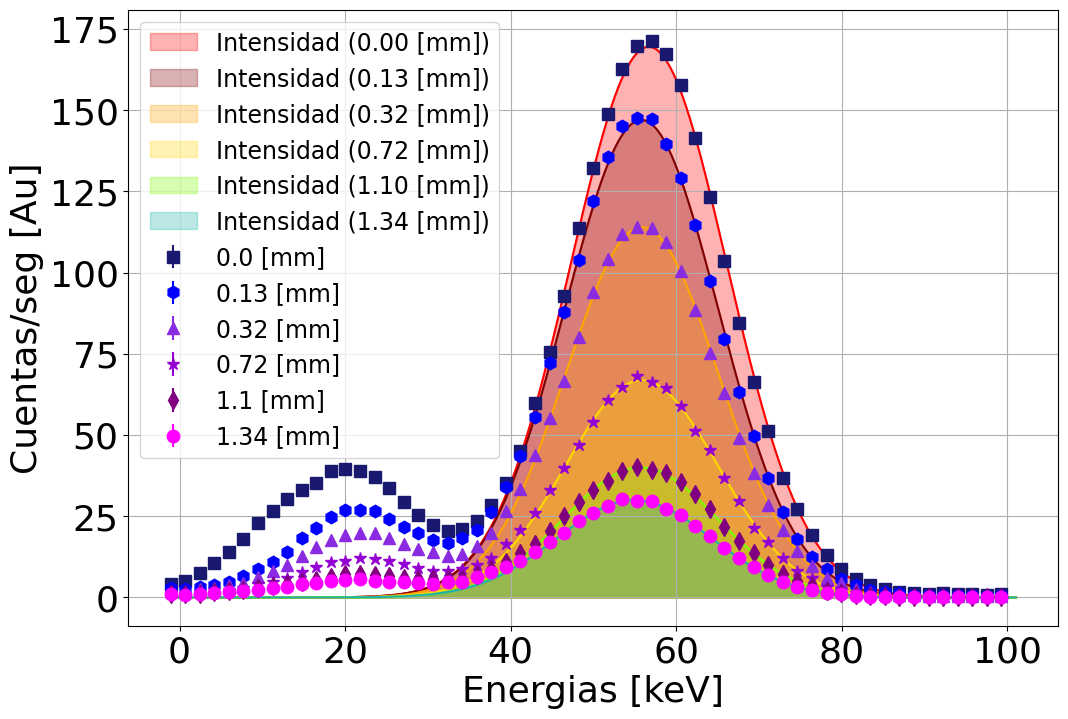

In [39]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Marcadores_plot=['s', 'h', '^', '*', 'd', 'o','x']
Label_Espesores=['0.0 [mm]', '0.13 [mm]', '0.32 [mm]', '0.72 [mm]', '1.1 [mm]', '1.34 [mm]']
Label_Int=['Intensidad (0.00 [mm])', 'Intensidad (0.13 [mm])', 'Intensidad (0.32 [mm])', 'Intensidad (0.72 [mm])', 'Intensidad (1.10 [mm])', 'Intensidad (1.34 [mm])']

Dom=np.linspace(Eje_Energia[7], Eje_Energia[65], 1000)

Int_Americio_g=[]
List_err_Int_Am=[]
List_Esp_Am=[]
List_Esp_Am_err=[]

c=0

for esp in Am.keys():

    List_Esp_Am+=[esp]
    List_Esp_Am_err.append(Am[esp][2])

Esp_Am=np.array(List_Esp_Am)
Esp_Am_err=np.array(List_Esp_Am_err)

plt.figure(figsize=(12,8))


for esp in Am.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[7:65], Am[esp][0][7:65], sigma=Am[esp][1][7:65], p0=[22,5,1,E_Am[0],2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Americio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Am.append(err_Int_g)
    
    plt.errorbar(Eje_Energia[7:65], Am[esp][0][7:65], yerr=Am[esp][1][7:65], fmt=Marcadores_plot[c], markersize= 9, color=Colores[c], label=Label_Espesores[c]) 
    
    plt.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    plt.fill_between(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c], alpha=0.3, label=Label_Int[c])
    c=c+1

plt.xlabel('Energias [keV]', fontsize=26)
plt.ylabel('Cuentas/seg [Au]', fontsize=26)
plt.grid()
plt.legend(fontsize=17)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.savefig('Espectros_Americio.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()

#array errores en la integral:
Int_Americio_g_err=np.array(List_err_Int_Am)


0.1456951201124563
0.0007109573518321455


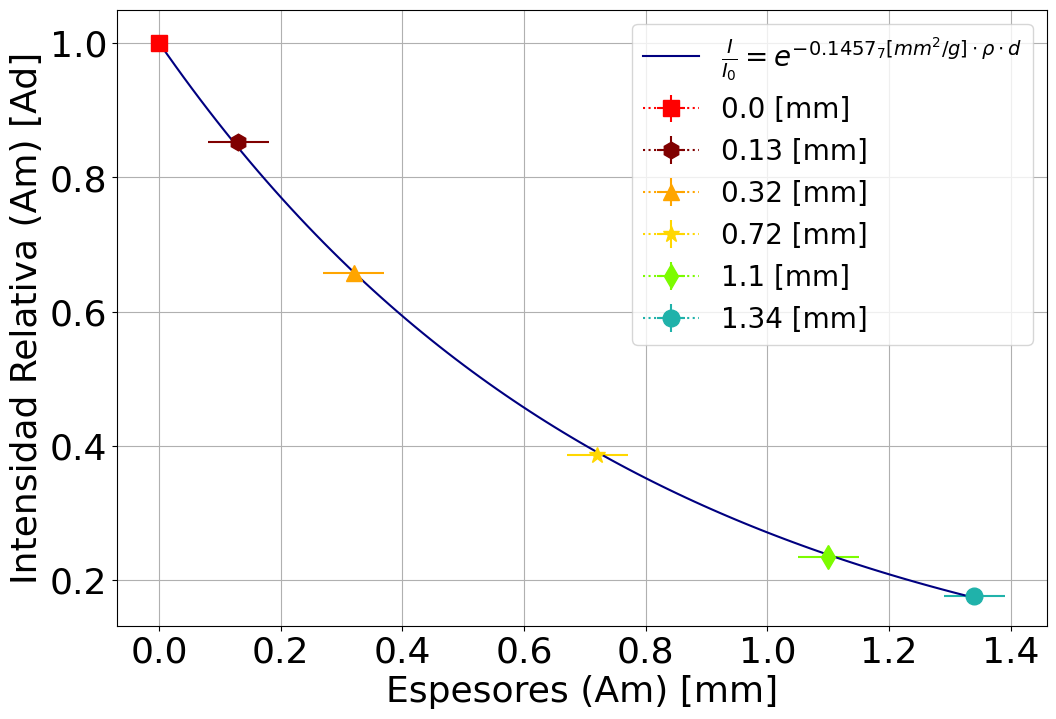

In [40]:
def L_B_Am(d, mu_m):

    I_I0=np.exp(-mu_m*8.96*d)
    return I_I0

Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen']
Marcadores_plot=['s:', 'h:', '^:', '*:', 'd:', 'o:','x:']

Int_Americio_g_norm=np.array(Int_Americio_g)/np.array(Int_Americio_g)[0]
Int_Americio_g_err_norm=np.array(Int_Americio_g_err)/np.array(Int_Americio_g)[0]

pop_Am, cov_Am = curve_fit(L_B_Am, Esp_Am, Int_Americio_g_norm, sigma= Int_Americio_g_err_norm)
err_Am = np.diag(np.sqrt(cov_Am))

print(pop_Am[0])
print(err_Am[0])

mu_Am=round(pop_Am[0],3)
mu_Am_err=round(err_Am[0],3)

# mu_masico_Am=mu_Am/8.96
# print(mu_masico_Am)

Cont_Am=np.linspace(Esp_Am[0], Esp_Am[len(Esp_Am)-1],100)

plt.figure(figsize=(12,8))

for n in range(0,6,1):
    plt.errorbar(Esp_Am[n], Int_Americio_g_norm[n], yerr=Int_Americio_g_err_norm[n], xerr=Esp_Am_err[n], fmt=Marcadores_plot[n], label=Label_Espesores[n], color=Colores_plot[n], markersize=12)

plt.plot(Cont_Am, L_B_Am(Cont_Am, pop_Am[0]), linestyle='-', color='navy', label=r'$\frac{I}{I_0}=e^{-0.1457_{7}[mm^2/g]\cdot\rho\cdot d}$')
plt.xlabel('Espesores (Am) [mm]', fontsize=26)
plt.ylabel('Intensidad Relativa (Am) [Ad]', fontsize=26)
plt.grid()
plt.legend(fontsize=20)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.savefig('atenuacion_americio_normalizado.jpg', format='jpg', dpi=1000, bbox_inches='tight')

plt.show()

## Sumas Riemann

### Sodio

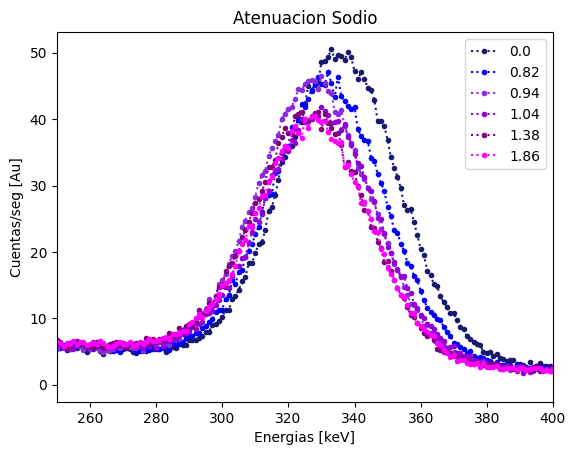

In [41]:
c=0
for esp in Na.keys():
    plt.errorbar(canales[10:], Na[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Sodio')
plt.xlim(250,400)
plt.legend()
plt.show()

 Primer Pico 511 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


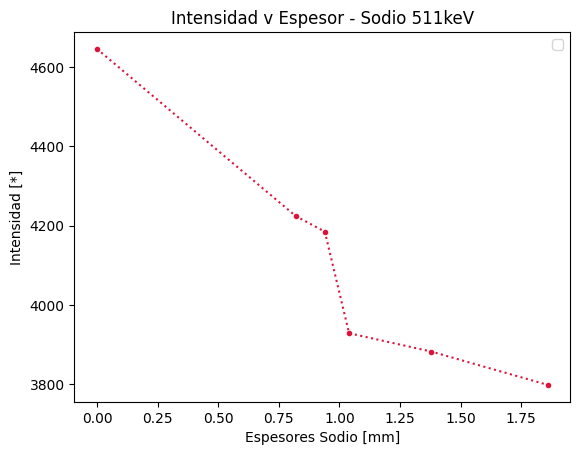

In [42]:
List_I_Na_511=[]
List_Esp_Na=[]

for esp in Na.keys():

    Int=Suma_Riemann(Eje_Energia, Na[esp][0], 250,400)
    List_I_Na_511+= [Int]
    List_Esp_Na+=[esp]

I_Na_511=np.array(List_I_Na_511)
Esp_Na=np.array(List_Esp_Na)

plt.errorbar(Esp_Na, I_Na_511, fmt='.:', color='crimson')
plt.xlabel('Espesores Sodio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Sodio 511keV')
plt.legend()
plt.show()

### Bario

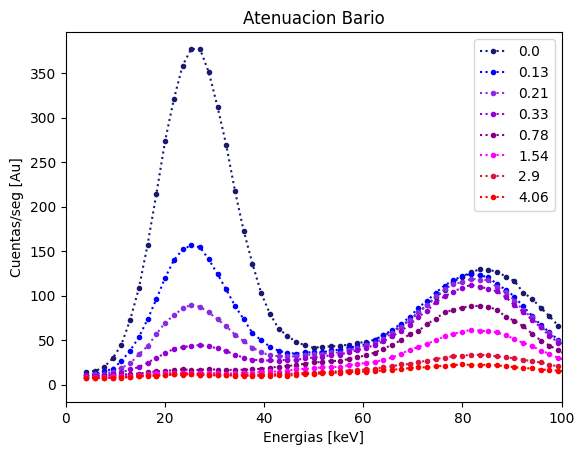

In [43]:
c=0
for esp in Ba.keys():
    plt.errorbar(Eje_Energia[10:], Ba[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Bario')
plt.xlim(0,100)
plt.legend()
plt.show()

 Primer Pico 31 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


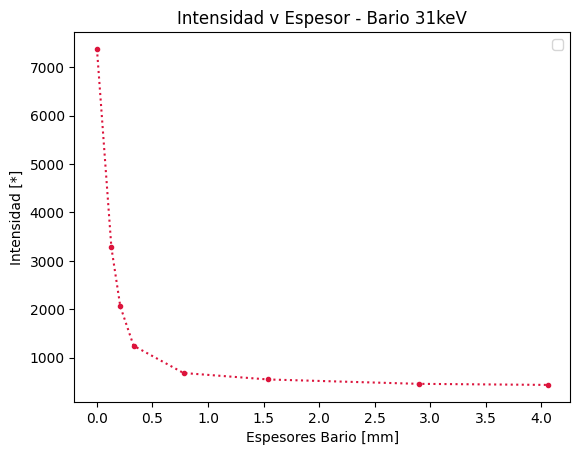

In [44]:
#Primer Pico 31keV

List_I_Ba_31=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 10, 35)
    List_I_Ba_31+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_31=np.array(List_I_Ba_31)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_31, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 31keV')
plt.legend()
plt.show()

Segundo Pico 81 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


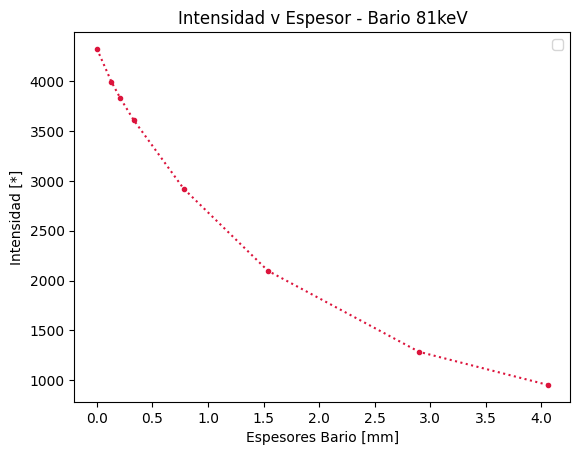

In [45]:
#Segundo Pico 81 keV

List_I_Ba_81=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 40,70)
    List_I_Ba_81+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_81=np.array(List_I_Ba_81)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_81, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 81keV')
plt.legend()
plt.show()

Tercer Pico 356 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


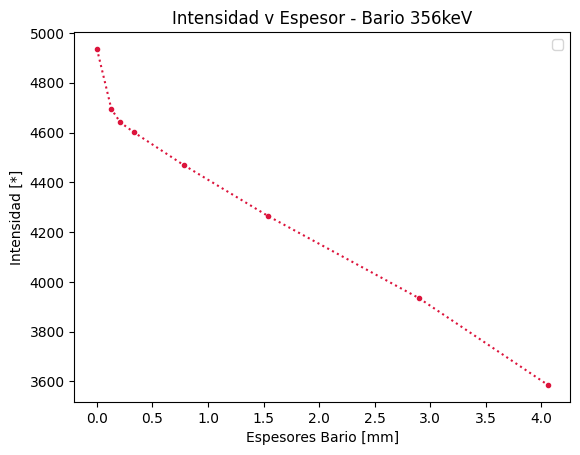

In [46]:
#Segundo Pico 81 keV

List_I_Ba_356=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 175,265)
    List_I_Ba_356+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_356=np.array(List_I_Ba_356)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_356, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 356keV')
plt.legend()
plt.show()

### Cobalto

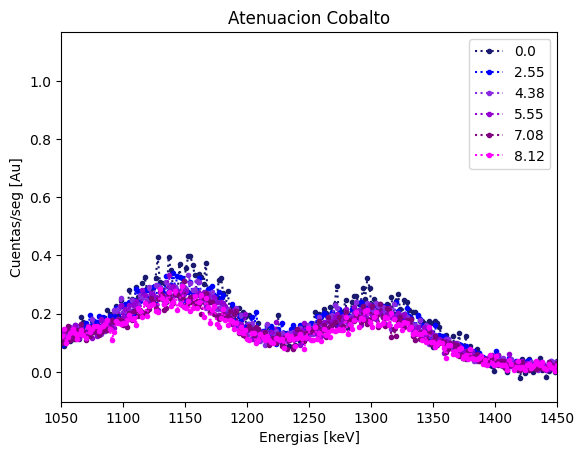

In [47]:
c=0
for esp in Co.keys():
    plt.errorbar(Eje_Energia[10:], Co[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Cobalto')
plt.xlim(1050,1450)
plt.legend()
plt.show()


Primer Pico 1173keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


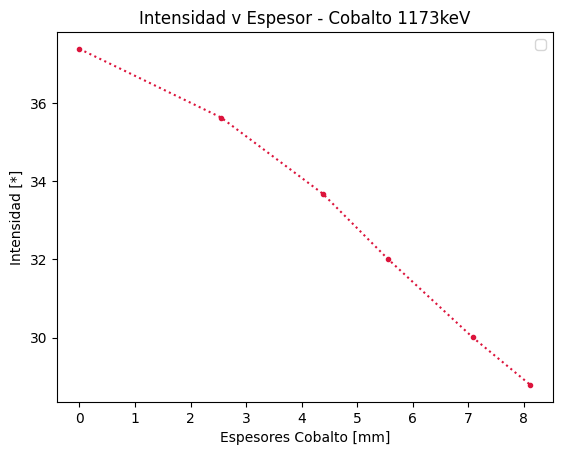

In [48]:
List_I_Co_1173=[]
List_Esp_Co=[]

for esp in Co.keys():

    Int=Suma_Riemann(Eje_Energia, Co[esp][0], 610,700)
    List_I_Co_1173+= [Int]
    List_Esp_Co+=[esp]

I_Co_1173=np.array(List_I_Co_1173)
Esp_Co=np.array(List_Esp_Co)

plt.errorbar(Esp_Co, I_Co_1173, fmt='.:', color='crimson')
plt.xlabel('Espesores Cobalto [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cobalto 1173keV')
plt.legend()
plt.show()

Segundo Pico 1332 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


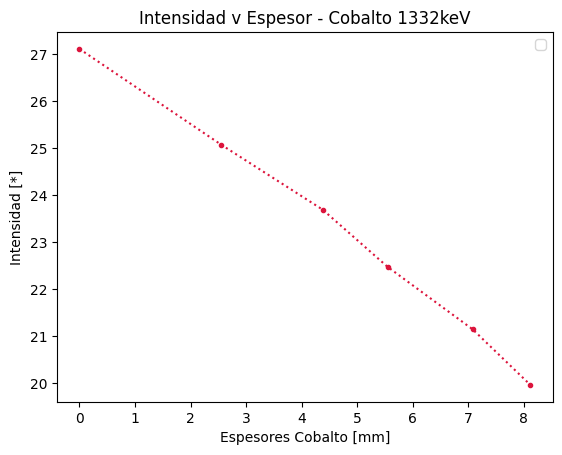

In [49]:
List_I_Co_1332=[]
List_Esp_Co=[]

for esp in Co.keys():

    Int=Suma_Riemann(Eje_Energia, Co[esp][0], 705,790)
    List_I_Co_1332+= [Int]
    List_Esp_Co+=[esp]

I_Co_1332=np.array(List_I_Co_1332)
Esp_Co=np.array(List_Esp_Co)

plt.errorbar(Esp_Co, I_Co_1332, fmt='.:', color='crimson')
plt.xlabel('Espesores Cobalto [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cobalto 1332keV')
plt.legend()
plt.show()

### Americio

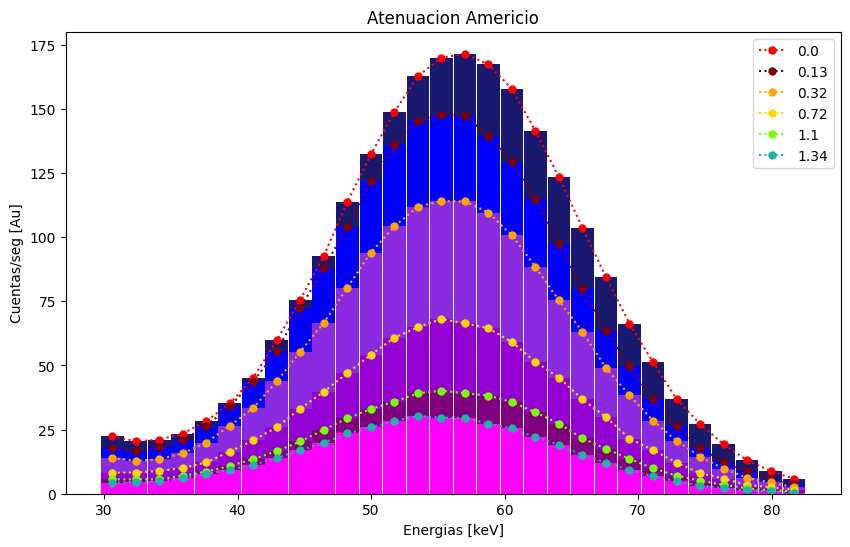

In [50]:
Colores_histo=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']

c=0

plt.figure(figsize=(10, 6))

for esp in Am.keys():
    plt.errorbar(Eje_Energia[25:55], Am[esp][0][25:55], fmt='o:', markersize= 5, color=Colores_histo[c], label=str(esp))
    plt.bar(Eje_Energia[25:55],Am[esp][0][25:55], width=1.7, color=Colores[c]) 
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Americio')
plt.legend()
plt.show()

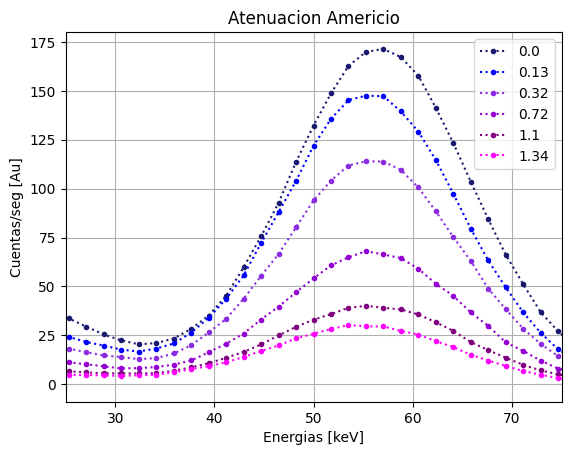

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


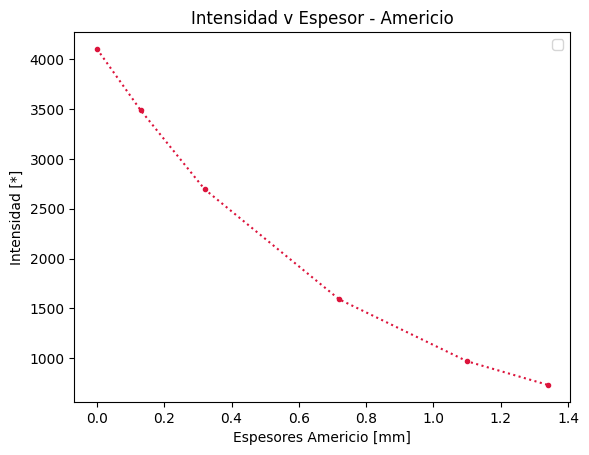

In [51]:
c=0
for esp in Am.keys():
    plt.errorbar(Eje_Energia[10:], Am[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Americio')
plt.xlim(25,75)
plt.grid()
plt.legend()
plt.show()

List_I_Am=[]
List_Esp_Am=[]

for esp in Am.keys():

    Int=Suma_Riemann(Eje_Energia, Am[esp][0], 25,55)
    List_I_Am+= [Int]
    List_Esp_Am+=[esp]

I_Am=np.array(List_I_Am)
Esp_Am=np.array(List_Esp_Am)

plt.errorbar(Esp_Am, I_Am, fmt='.:', color='crimson')
plt.xlabel('Espesores Americio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Americio')
plt.legend()
plt.show()

### Cesio

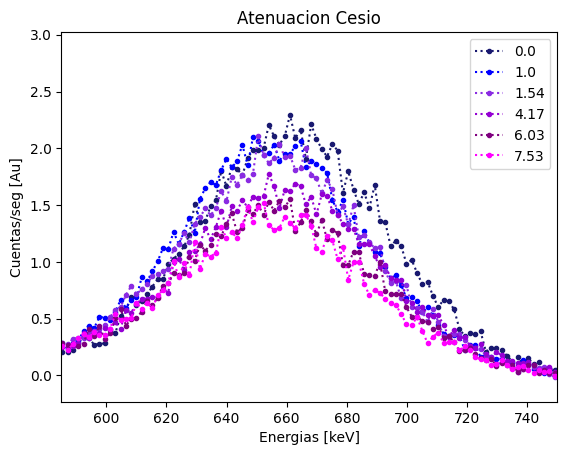

In [52]:
c=0

for esp in Cs.keys():
    plt.errorbar(Eje_Energia[10:], Cs[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Cesio')
plt.xlim(585,750)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


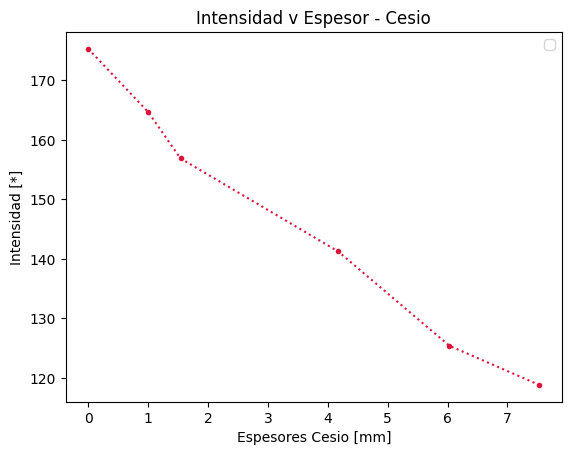

In [53]:
List_I_Cs=[]
List_Esp_Cs=[]

for esp in Cs.keys():

    Int=Suma_Riemann(Eje_Energia, Cs[esp][0], 325,440)
    List_I_Cs+= [Int]
    List_Esp_Cs+=[esp]

I_Cs=np.array(List_I_Cs)
Esp_Cs=np.array(List_Esp_Cs)

plt.errorbar(Esp_Cs, I_Cs, fmt='.:', color='crimson')
plt.xlabel('Espesores Cesio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cesio')
plt.legend()
plt.show()

# Lambert -  Beer

## Por Integral Normal

In [54]:
def L_B(d, mu_l, C):

    I_I0=np.exp(-mu_l*d)+C
    return I_I0

In [107]:
Int_s=[Int_Bario_31_g, Int_Americio_g, Int_Bario_81_g, Int_Bario_356_g, Int_Cesio_g, Int_Cobalto_1173_g, Int_Cobalto_1332_g]
Int_s_err=[Int_Bario_31_g_err, Int_Americio_g_err, Int_Bario_81_g_err, Int_Bario_356_g_err, Int_Cesio_g_err, Int_Cobalto_1173_g_err, Int_Cobalto_1332_g_err]

Espesores_Int= [Esp_Ba_31, Esp_Am, Esp_Ba_81, Esp_Ba_356, Esp_Cs, Esp_Co_1173, Esp_Co_1332]
Espesores_Int_err= [Esp_Ba_31_err, Esp_Am_err, Esp_Ba_81_err, Esp_Ba_356_err, Esp_Cs_err, Esp_Co_1173_err, Esp_Co_1332_err]

print(Esp_Ba_31)

Int_I0=[]

for i in Int_s:

    for j in range(len(i)):

        I_I0=i[j]/i[0]
        Int_I0.append(I_I0)

sublistas_Int = []
temp_lista_Int = []

for valor in Int_I0:
    if valor == 1.0:
        if temp_lista_Int:
            sublistas_Int.append(temp_lista_Int)
            temp_lista_Int = []
        temp_lista_Int.insert(0, valor) # Inserta el valor 1.0 al principio de la sublista
    else:
        temp_lista_Int.append(valor)

# Añadir la última sublista si no está vacía
if temp_lista_Int:
    sublistas_Int.append(temp_lista_Int)


Int_I0_Ba_31=np.array(sublistas_Int[0]) #0
Int_I0_Am_Int=np.array(sublistas_Int[1]) #1
Int_I0_Ba_81_Int=np.array(sublistas_Int[2]) #2
Int_I0_Ba_356_Int=np.array(sublistas_Int[3]) #3
Int_I0_Cs_Int=np.array(sublistas_Int[4]) #4
Int_I0_Co_1173_Int=np.array(sublistas_Int[5]) #5
Int_I0_Co_1332_Int=np.array(sublistas_Int[6]) #6
#Int_I0_Na_511_Int=np.array(sublistas_Int[7]) #7

[0.   0.13 0.21 0.33 4.06]


Lineal Absortion Coefficient del  Bario 31[keV] : 6.725825247715725 Constante:  0.05015847114343775
Errores:  0.9070070809877643 0.03355287390425385


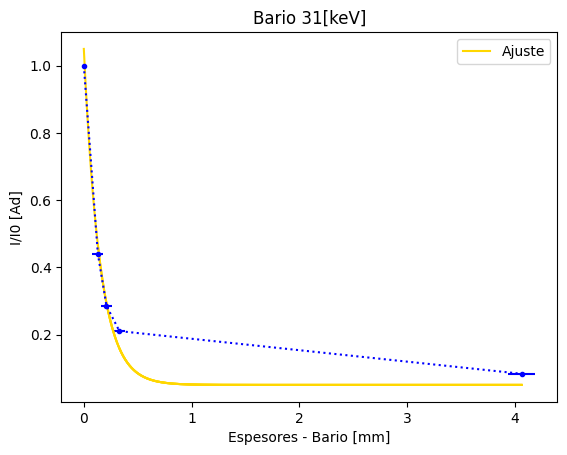

Lineal Absortion Coefficient del  Americio 59[keV] : 1.3262537449528644 Constante:  0.004012565821417415
Errores:  0.01905529497009886 0.0038844293875489777


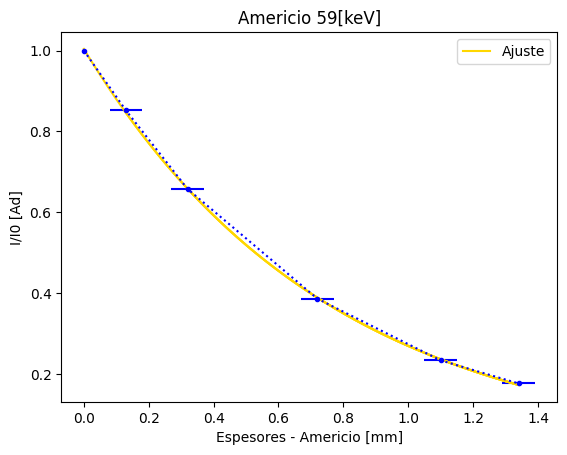

Lineal Absortion Coefficient del  Bario 81[keV] : 0.32710876728763655 Constante:  -0.04859898074306972
Errores:  0.04029754508241123 0.02472090398996716


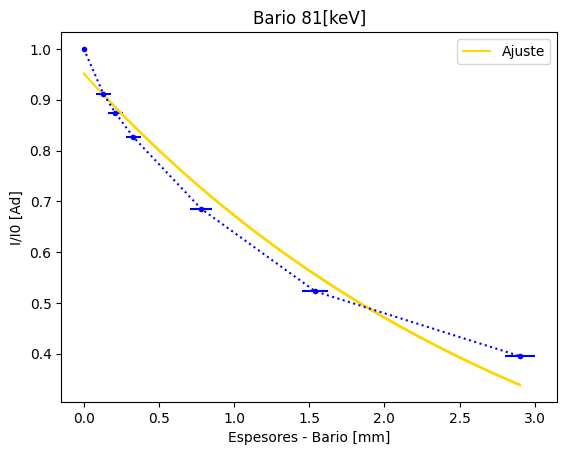

Lineal Absortion Coefficient del  Bario 356[keV] : 0.05315449673730617 Constante:  -0.04584850679540963
Errores:  0.006929197628921763 0.010852168276999925


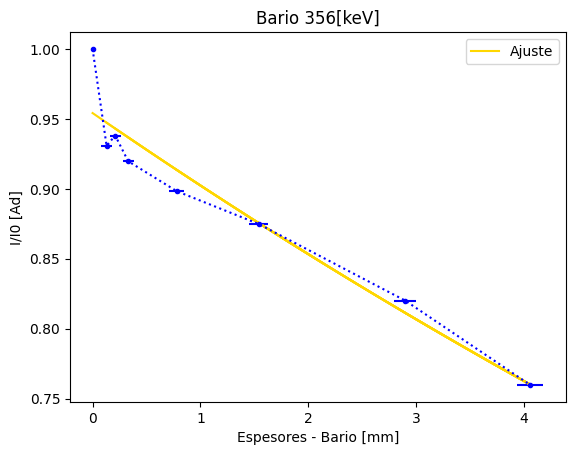

Lineal Absortion Coefficient del  Cesio 662[keV] : 0.05183674206618173 Constante:  -0.0102673229966153
Errores:  0.0027883864091851895 0.008791388093928622


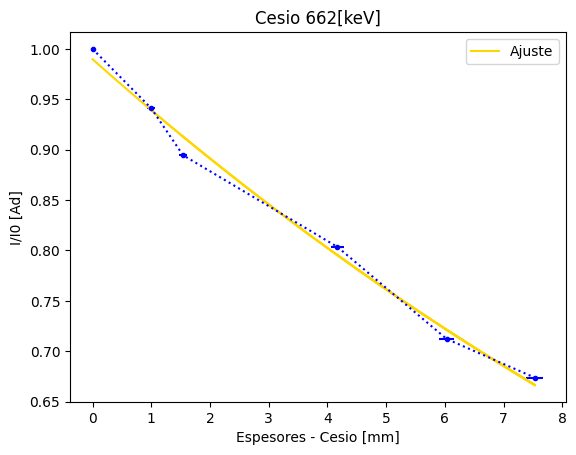

Lineal Absortion Coefficient del  Cobalto 1173[keV] : 0.017196891761363808 Constante:  0.0069722525118396704
Errores:  0.0023220362632838266 0.011890662180267186


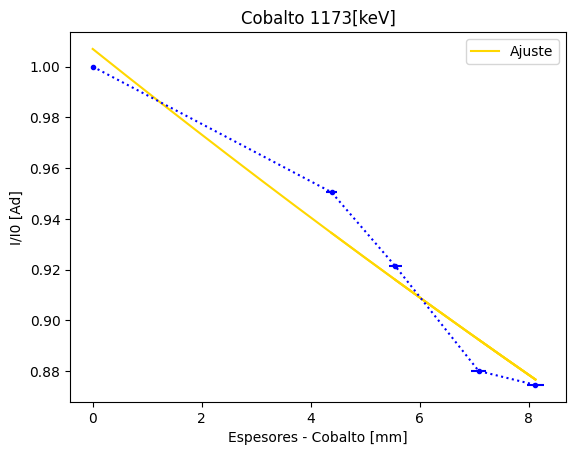

Lineal Absortion Coefficient del  Cobalto 1332[keV] : 0.04341880140776164 Constante:  0.019918685165982362
Errores:  0.005719984329751711 0.023002327396184897


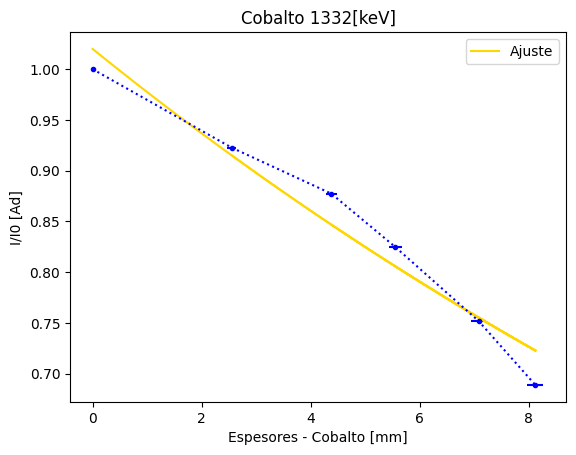

In [105]:
List_Mu_L_Int=[]
List_err_Mu_L_Int=[]
Energias_mu_Int=np.array([31, 59,   81. ,  356. , 662. ,  1173, 1332])

Espesores_nom_Int=['Espesores - Bario [mm]','Espesores - Americio [mm]','Espesores - Bario [mm]','Espesores - Bario [mm]','Espesores - Cesio [mm]','Espesores - Cobalto [mm]','Espesores - Cobalto [mm]']
Titulos_Int=['Bario 31[keV]','Americio 59[keV]','Bario 81[keV]','Bario 356[keV]','Cesio 662[keV]','Cobalto 1173[keV]','Cobalto 1332[keV]']

n = 0

for lista_int in sublistas_Int:

    array = np.array(lista_int)
    pop, cov = curve_fit(L_B, Espesores_Int[n], array)
    err = np.diag(np.sqrt(cov))

    print('Lineal Absortion Coefficient del ', Titulos_Int[n],':', pop[0], 'Constante: ', pop[1])
    print('Errores: ', err[0], err[1])

    List_Mu_L_Int.append(pop[0])
    List_err_Mu_L_Int.append(err[0])

    continuo = np.linspace(Espesores_Int[n], Espesores_Int[n][len(Espesores_Int[n])-1], 1000)

    plt.errorbar(Espesores_Int[n], array, xerr=Espesores_Int_err[n], fmt='.:', color='blue')
    plt.plot(continuo, L_B(continuo, pop[0], pop[1]), color='gold', label='Ajuste')
    plt.xlabel(Espesores_nom_Int[n])
    plt.ylabel('I/I0 [Ad]')
    plt.title(Titulos_Int[n])

    # Obtén los handles y labels actuales
    handles, labels = plt.gca().get_legend_handles_labels()
    # Crea un diccionario ordenado para almacenar los labels únicos
    by_label = OrderedDict(zip(labels, handles))
    # Pasa los valores y keys únicos al legend
    plt.legend(by_label.values(), by_label.keys())

    plt.show()
    n = n + 1

Mu_L_Int=np.array(List_Mu_L_Int)
Mu_L_Int_err=np.array(List_err_Mu_L_Int)

### Efectos Radiacion - Materia

In [57]:
def Busc_de_Canales(E, p, b):

    return (E-b)/p

Canales_Mu_func=Busc_de_Canales(Energias_mu_Int, pendiente, ordenada)

Canales_Mu_list=[]

for i in Canales_Mu_func:
    
    a=int(i)
    b=float(a)

    Canales_Mu_list.append(b)

Canales_Mu=np.array(Canales_Mu_list)

Energias_mu_Int_err=err_lineal(Canales_Mu, pendiente, 1, err_p, err_b)

In [58]:
E_cal=[]
E_unsorted=[E_Am_cal, E_Ba_cal, E_Co_cal, E_Cs_cal]

for i in E_unsorted:
    for j in i:
        E_cal.append(j)


Energias_cal=sorted(E_cal)
print(Energias_cal)

[27, 57, 82, 393, 660, 1141, 1308]


## Por sumas de Riemann

Paso todas  las intensidades a su cociente con I0 respectivo:

In [65]:
I_s=[I_Ba_31, I_Am, I_Ba_81, I_Ba_356, I_Cs, I_Co_1173,I_Co_1332]
Espesores= [Esp_Ba, Esp_Am, Esp_Ba, Esp_Ba, Esp_Cs, Esp_Co, Esp_Co]

I_I0_s=[]

for i in I_s:

    for j in range(len(i)):

        I_I0=i[j]/i[0]
        I_I0_s.append(I_I0)

sublistas = []
temp_lista = []

for valor in I_I0_s:
    if valor == 1.0:
        if temp_lista:
            sublistas.append(temp_lista)
            temp_lista = []
        temp_lista.insert(0, valor) # Inserta el valor 1.0 al principio de la sublista
    else:
        temp_lista.append(valor)

# Añadir la última sublista si no está vacía
if temp_lista:
    sublistas.append(temp_lista)


I_I0_Ba_31=np.array(sublistas[0]) #0
I_I0_Am=np.array(sublistas[1]) #1
I_I0_Ba_81=np.array(sublistas[2]) #2
I_I0_Ba_356=np.array(sublistas[3]) #3
I_I0_Cs=np.array(sublistas[4]) #4
I_I0_Co_1173=np.array(sublistas[5]) #5
I_I0_Co_1332=np.array(sublistas[6]) #6
#I_I0_Na_511=np.array(sublistas[7]) #7

In [66]:
Mu_L=[]
err_Mu_L=[]
Energias_mu=np.array([31. , 59. ,   81. ,  356. , 662. ,  1173, 1332])

Espesores_nom=['Espesores - Bario [mm]','Espesores - Americio [mm]','Espesores - Bario [mm]','Espesores - Bario [mm]','Espesores - Cesio [mm]','Espesores - Cobalto [mm]','Espesores - Cobalto [mm]']
Titulos=['Bario 31[keV]','Americio 59[keV]','Bario 81[keV]','Bario 356[keV]','Cesio 662[keV]','Cobalto 1173[keV]','Cobalto 1332[keV]']

n = 0

for lista_int in sublistas:
    
    array = np.array(lista_int)
    pop, cov = curve_fit(L_B, Espesores[n], array)
    err = np.diag(np.sqrt(cov))

    # print(pop[0], pop[1])
    # print(err[0], err[1])

    Mu_L.append(pop[0])
    err_Mu_L.append(err[0])

    continuo = np.linspace(Espesores[n], Espesores[n][len(Espesores[n])-1], 1000)

    # plt.errorbar(Espesores[n], array, fmt='.:', color='blue')
    # plt.plot(continuo, L_B(continuo, pop[0], pop[1]), color='gold', label='Ajuste')
    # plt.xlabel(Espesores_nom[n])
    # plt.ylabel('I/I0 [Ad]')
    # plt.title(Titulos[n])

    # # Obtén los handles y labels actuales
    # handles, labels = plt.gca().get_legend_handles_labels()
    # # Crea un diccionario ordenado para almacenar los labels únicos
    # by_label = OrderedDict(zip(labels, handles))
    # # Pasa los valores y keys únicos al legend
    # plt.legend(by_label.values(), by_label.keys())

    # plt.show()
    n = n + 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


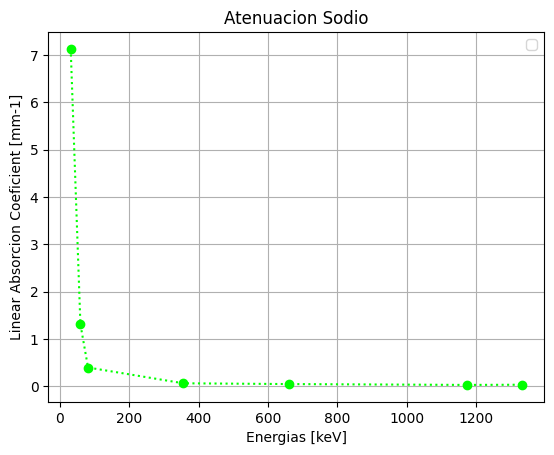

In [67]:
plt.errorbar(Energias_mu,np.array(Mu_L), fmt='o:', color='lime')
plt.xlabel('Energias [keV]')
plt.ylabel('Linear Absorcion Coeficient [mm-1]')
plt.title('Atenuacion Sodio')
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.6870305488341715
[0.00316844]


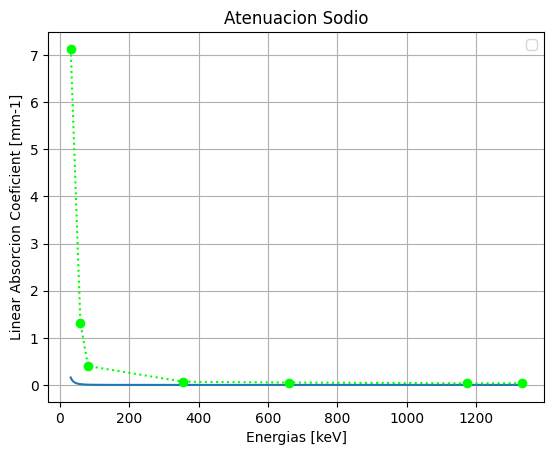

In [68]:
def Ef_ph(E, A):
    sig=A*(29**4)/(E**3.5)
    return sig

pop_ph, cov_ph= curve_fit(Ef_ph, Energias_mu, np.array(Mu_L))

err_ph=np.sqrt(np.diag(cov))
print(pop_ph[0])
print(cov_ph[0])

dom=np.linspace(Energias_mu[0], Energias_mu[len(Energias_mu)-1], 10000)

plt.errorbar(Energias_mu,np.array(Mu_L), fmt='o:', color='lime')
plt.plot(dom, Ef_ph(dom, pop[0]))
plt.xlabel('Energias [keV]')
plt.ylabel('Linear Absorcion Coeficient [mm-1]')
plt.title('Atenuacion Sodio')
plt.grid()
plt.legend()
plt.show()